
## Understanding the aims of the research 

To understand the methodology and methods carried out in this notebook, refer to [Research on Representation - Diffusion Models](https://github.com/RehanAhmad13/Diffusion-Models/blob/main/Research_on_Representation.pdf). Work in progress so hopefully I will update everything soon. 



In [1]:
!pip install huggingface_hub==0.25.1
!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install diffusers==0.17.1
!pip install requests==2.27.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 7.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

In [2]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import shutil
from torch.optim.adam import Adam
from PIL import Image

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.20) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Attention_Control 

In [3]:
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import cv2
from typing import Optional, Union, Tuple, List, Callable, Dict
from IPython.display import display
from tqdm.notebook import tqdm



    
def get_word_inds(text: str, word_place: int, tokenizer):
    split_text = text.split(" ")
    if type(word_place) is str:
        word_place = [i for i, word in enumerate(split_text) if word_place == word]
    elif type(word_place) is int:
        word_place = [word_place]
    out = []
    if len(word_place) > 0:
        words_encode = [tokenizer.decode([item]).strip("#") for item in tokenizer.encode(text)][1:-1]
        cur_len, ptr = 0, 0

        for i in range(len(words_encode)):
            cur_len += len(words_encode[i])
            if ptr in word_place:
                out.append(i + 1)
            if cur_len >= len(split_text[ptr]):
                ptr += 1
                cur_len = 0
    return np.array(out)


def update_alpha_time_word(alpha, bounds: Union[float, Tuple[float, float]], prompt_ind: int,
                           word_inds: Optional[torch.Tensor]=None):
    if type(bounds) is float:
        bounds = 0, bounds
    start, end = int(bounds[0] * alpha.shape[0]), int(bounds[1] * alpha.shape[0])
    if word_inds is None:
        word_inds = torch.arange(alpha.shape[2])
    alpha[: start, prompt_ind, word_inds] = 0
    alpha[start: end, prompt_ind, word_inds] = 1
    alpha[end:, prompt_ind, word_inds] = 0
    return alpha


def get_time_words_attention_alpha(prompts, num_steps,
                                   cross_replace_steps: Union[float, Dict[str, Tuple[float, float]]],
                                   tokenizer, max_num_words=77):
    if type(cross_replace_steps) is not dict:
        cross_replace_steps = {"default_": cross_replace_steps}
    if "default_" not in cross_replace_steps:
        cross_replace_steps["default_"] = (0., 1.)
    alpha_time_words = torch.zeros(num_steps + 1, len(prompts) - 1, max_num_words)
    for i in range(len(prompts) - 1):
        alpha_time_words = update_alpha_time_word(alpha_time_words, cross_replace_steps["default_"],
                                                  i)
    for key, item in cross_replace_steps.items():
        if key != "default_":
             inds = [get_word_inds(prompts[i], key, tokenizer) for i in range(1, len(prompts))]
             for i, ind in enumerate(inds):
                 if len(ind) > 0:
                    alpha_time_words = update_alpha_time_word(alpha_time_words, item, i, ind)
    alpha_time_words = alpha_time_words.reshape(num_steps + 1, len(prompts) - 1, 1, 1, max_num_words)
    return alpha_time_words


class EmptyControl:
    
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn



def register_attention_control(model, controller):
    def ca_forward(self, place_in_unet):
        to_out = self.to_out
        if isinstance(to_out, torch.nn.modules.container.ModuleList):
            to_out = self.to_out[0]
    
        def forward(hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):
            is_cross = encoder_hidden_states is not None
    
            residual = hidden_states
    
            if self.spatial_norm is not None:
                hidden_states = self.spatial_norm(hidden_states, temb)
    
            input_ndim = hidden_states.ndim
    
            if input_ndim == 4:
                batch_size, channel, height, width = hidden_states.shape
                hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
    
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)
    
            if self.group_norm is not None:
                hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)
    
            query = self.to_q(hidden_states)
    
            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            elif self.norm_cross:
                encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)
    
            key = self.to_k(encoder_hidden_states)
            value = self.to_v(encoder_hidden_states)
    
            query = self.head_to_batch_dim(query)
            key = self.head_to_batch_dim(key)
            value = self.head_to_batch_dim(value)
            #print("dim of query is ", query.shape)
            
    
            attention_probs = self.get_attention_scores(query, key, attention_mask)
            #print("attention probs are ", attention_probs.shape)
            attention_probs = controller(attention_probs, key, query, is_cross, place_in_unet)
    
            hidden_states = torch.bmm(attention_probs, value)
            hidden_states = self.batch_to_head_dim(hidden_states)
    
            hidden_states = to_out(hidden_states)
    
            if input_ndim == 4:
                hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)
    
            if self.residual_connection:
                hidden_states = hidden_states + residual
    
            hidden_states = hidden_states / self.rescale_output_factor
    
            return hidden_states
    
        return forward

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == 'Attention':
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    
    # Check if the model is wrapped in DataParallel
    unet = model.module.unet if isinstance(model, torch.nn.DataParallel) else model.unet

    cross_att_count = 0
    sub_nets = unet.named_children()  # Access unet directly
    for net in sub_nets:
        if "down" in net[0]:
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            cross_att_count += register_recr(net[1], 0, "mid")

    controller.num_att_layers = cross_att_count


    
class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, key, query, is_cross: bool, place_in_unet: str):
        h = attn.shape[0]
        attn[h // 2:] = self.forward(attn[h // 2:], key, query, is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn


    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0
        
class EmptyControl(AttentionControl):

    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn



    

class AttentionStore(AttentionControl):
    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        self.selected_timesteps_store = {}  # Store attention maps for specific timesteps
        self.keys_queries_store = {}  # Store keys and queries only for self-attention

    @staticmethod
    def get_empty_store():
        return {
            "down_self": [], "mid_self": [], "up_self": [],  # Store self-attention (only at 32x32 resolution)
            "down_cross": [], "mid_cross": [], "up_cross": []  # Store cross-attention (at all resolutions)
        }

    def forward(self, attn, key, query, is_cross: bool, place_in_unet: str):
        key_attn = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        #print("cur step is",self.cur_step)
        # Store attention maps for t = 5
        if self.cur_step == 1:
            if self.cur_step not in self.selected_timesteps_store:
                self.selected_timesteps_store[self.cur_step] = {}

            # Ensure the key exists in the store
            if key_attn not in self.selected_timesteps_store[self.cur_step]:
                self.selected_timesteps_store[self.cur_step][key_attn] = []
            # Self-attention is only stored if resolution is 32x32
            if not is_cross and attn.shape[1] != 32 ** 2:
                return attn  # Skip storing if it's not at the required resolution
            # Store attention maps
            self.selected_timesteps_store[self.cur_step][key_attn].append(attn.clone().detach())

            # Only store queries and keys for self-attention (and only at 32x32 resolution)
            if not is_cross:
                if self.cur_step not in self.keys_queries_store:
                    self.keys_queries_store[self.cur_step] = {}

                if key_attn not in self.keys_queries_store[self.cur_step]:
                    self.keys_queries_store[self.cur_step][key_attn] = {"keys": [], "queries": []}

                self.keys_queries_store[self.cur_step][key_attn]["keys"].append(key.clone().detach())
                self.keys_queries_store[self.cur_step][key_attn]["queries"].append(query.clone().detach())

        return attn

    def between_steps(self):
        # Average the step_store and accumulate
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        # Average the attention maps across all timesteps
        average_attention = {
            key: [item / self.cur_step for item in self.attention_store[key]]
            for key in self.attention_store
        }
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        self.selected_timesteps_store = {}  # Reset the store for specific timesteps
        self.keys_queries_store = {}  # Reset the keys and queries store




def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    #print("after averaging", type(attention_maps))
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            #print("after averaging", item.shape)
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                #print("cross_",cross_maps.shape)
                #print("after")
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    #print("out shape is ", out.shape)
    out = out.sum(0) / out.shape[0]
    #print("out shape is", out.shape)
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    view_images(np.stack(images, axis=0))





def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(1, 77)
    
    for word, val in zip(word_select, values):
        inds = get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer



def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    view_images(np.concatenate(images, axis=1))

# Model pipeline 

In [4]:
from huggingface_hub import login
login("") # Enter your login here 

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
MY_TOKEN = '' # Enter your token here 
token=MY_TOKEN
use_auth_token=MY_TOKEN


In [6]:
# Initialize scheduler
scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False
)


# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the pipeline and move to device
ldm_stable = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    use_auth_token=MY_TOKEN,
    scheduler=scheduler
).to(device)

# Try disabling xformers memory-efficient attention
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")

# Access the tokenizer
tokenizer = ldm_stable.tokenizer

# Debug output to confirm device placement
print(f"Pipeline loaded on device: {device}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:131: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.17.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for th

Pipeline loaded on device: cuda:0


# P2P code 

In [7]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

Path exists!
Image size: (459, 457)


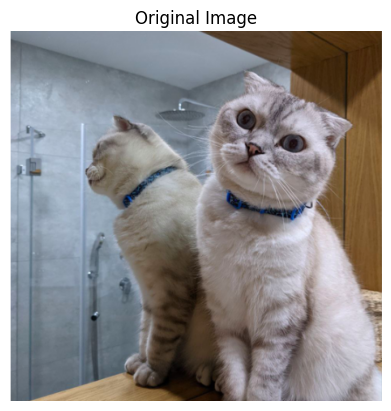

In [8]:
import matplotlib.pyplot as plt
import os
# Define the image path
image_path = '/kaggle/input/catoos/Dataset_Cats/source_cat.png'

# Check if the file exists
if os.path.exists(image_path):
    print("Path exists!")
    # Load and display the image
    img = Image.open(image_path)
    print("Image size:", img.size)  # Print the size of the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title("Original Image")
    plt.show()
else:
    print("Path does not exist.")


In [9]:
LOW_RESOURCE = True
NUM_DDIM_STEPS = 10
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77

In [10]:
def init_random_noise(device, num_words=77):
    return torch.randn(1, num_words, 768).to(device)


class DDIM_Inversion:

    def __init__(self, model, controller=None):
        scheduler = DDIMScheduler(
            beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
            clip_sample=False, set_alpha_to_one=False
        )
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None

        # Register the controller for attention
        if controller is None:
            controller = EmptyControl()  # Default to no-op control
        self.controller = controller
        register_attention_control(self.model, self.controller)

    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)  # Duplicate latents for guidance
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE

        # Noise prediction with attention control
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: Optional[str] = None):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
    
        if prompt is None:
            print("random")
            text_embeddings = init_random_noise(self.model.device)
        else:
            text_input = self.model.tokenizer(
                [prompt],
                padding="max_length",
                max_length=self.model.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
    
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt if prompt is not None else "random_noise"


    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        # Convert image to latent space
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)

        # Perform DDIM inversion loop with attention control
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    def invert(
        self,
        image_path: str,
        prompt: str,
        offsets=(0, 0, 0, 0),
        num_inner_steps=10,
        early_stop_epsilon=1e-5,
        verbose=False
    ):
        """
        Inverts an input image into latent space and applies the controller during DDIM inversion.
    
        Parameters:
        - image_path (str): Path to the input image.
        - prompt (str): Text prompt for conditioning.
        - offsets (tuple): Offsets for image cropping or alignment.
        - num_inner_steps (int): Number of steps for internal iterations (optional).
        - early_stop_epsilon (float): Threshold for early stopping.
        - verbose (bool): Verbose logging.
        """
    
        # Initialize the text prompt and register attention control
        self.init_prompt(prompt)
        register_attention_control(self.model, self.controller)
    
        # Load and preprocess the input image
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
    
        # Perform DDIM inversion
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
    
        # Return the ground truth image, reconstructed image, and final latent
        return (image_gt, image_rec), ddim_latents[-1]
        

In [11]:
prompt = None
controller = AttentionStore()  # Track attention maps
ddim_inversion = DDIM_Inversion(ldm_stable, controller=controller)

# Perform inversion
(image_gt, image_enc), x_t = ddim_inversion.invert(image_path, prompt, offsets=(0, 0, 0), verbose=True)

random
DDIM inversion...


# Accessing Queries & Keys 

In [12]:
# Access the stored queries and keys at specific timesteps
keys_queries_dict = controller.keys_queries_store

# Print available timesteps
print(keys_queries_dict.keys())  # Example: [0, 5, 10, ..., 45]

# Number of stored timesteps
print(f"Number of stored timesteps with keys/queries: {len(keys_queries_dict)}")


# Access keys and queries for a specific timestep (e.g., timestep 5)
timestep = 1
if timestep in keys_queries_dict:
    timestep_data = keys_queries_dict[timestep]
    
    # Print the keys (e.g., "down_self", "mid_self", "up_self")
    print(f"Available keys at timestep {timestep}: {timestep_data.keys()}")

    # Access specific keys and queries for "down_self"
    if "down_self" in timestep_data:
        down_self_data = timestep_data["down_self"]
        down_self_keys = down_self_data["keys"]  # List of stored key tensors
        down_self_queries = down_self_data["queries"]  # List of stored query tensors
        
        print(f"Number of keys stored for 'down_self' at timestep {timestep}: {len(down_self_keys)}")
        print(f"Number of queries stored for 'down_self' at timestep {timestep}: {len(down_self_queries)}")
        
        # Example: Inspect a specific key or query tensor
        print(f"Shape of the first key tensor for 'down_self': {down_self_keys[0].shape}")
        print(f"Shape of the first query tensor for 'down_self': {down_self_queries[0].shape}")


dict_keys([1])
Number of stored timesteps with keys/queries: 1
Available keys at timestep 1: dict_keys(['down_self', 'up_self'])
Number of keys stored for 'down_self' at timestep 1: 2
Number of queries stored for 'down_self' at timestep 1: 2
Shape of the first key tensor for 'down_self': torch.Size([8, 1024, 80])
Shape of the first query tensor for 'down_self': torch.Size([8, 1024, 80])


# Coordinate Convertor 
- Source Left Ear = (5, 20) , (5, 21), (5,22), (5,23), (4, 20), (4,21), (4,22)
- Source Right Ear = (8, 28) , (8, 29), (8,27), (7,27), (9,28)
- Farmost Ear - (8,9), (8,10), (7,9)
- Leg - (30, 11), (30, 12), (30, 13), (29,13), (29,12), (29,11)
- Mouth - (12, 20), (12,21)
- Nose - (10, 21) 


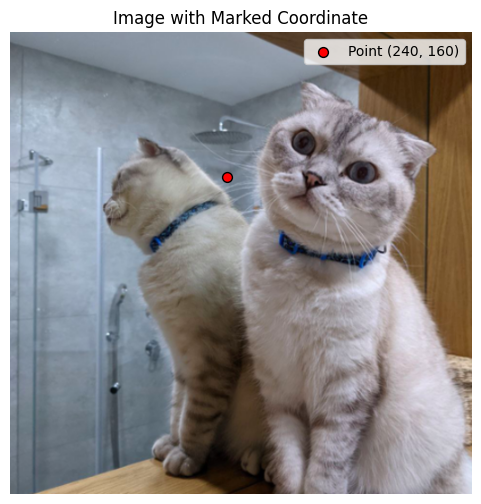

In 64 x 64 grid ( 20.8125  ,  15.0 )


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_point_on_image(image_path, point, marker_color='red', marker_size=50):
    """
    Loads an image, resizes it to 512x512, and marks a given coordinate.

    Parameters:
    - image_path (str): Path to the image file.
    - point (tuple): Coordinate (x, y) to mark on the image.
    - marker_color (str): Color of the marker (default is 'red').
    - marker_size (int): Size of the marker (default is 50).

    Returns:
    - None (displays the image with the marked point).
    """
    # Load and resize the image
    image = load_512(image_path)
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.scatter(point[0], point[1], color=marker_color, s=marker_size, edgecolors='black', label=f"Point {point}")
    
    # Customize the visualization
    plt.axis('off')  # Hide axes
    plt.legend(loc="upper right")
    plt.title("Image with Marked Coordinate")

    # Show the result
    plt.show()

# Example usage
image_path = '/kaggle/input/catoos/Dataset_Cats/source_cat.png'
point_of_interest = (240, 160)  # Example coordinate

visualize_point_on_image(image_path, point_of_interest)

print("In 64 x 64 grid (", (333/512)*32, " , " ,((240/512)*32),")")

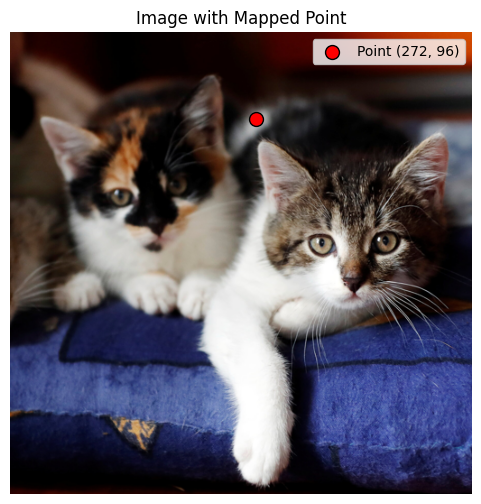

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def map_32_to_512(point_32):
    """
    Maps a coordinate from a 32x32 grid to a 512x512 grid.

    Parameters:
    - point_32 (tuple): (x, y) coordinate in 32x32 space.

    Returns:
    - tuple: Corresponding (x, y) coordinate in 512x512 space.
    """
    scale_factor = 512 / 32  # Scaling factor from 32 to 512
    x_512 = int(point_32[0] * scale_factor)
    y_512 = int(point_32[1] * scale_factor)
    return (x_512, y_512)

def load_512_img(image_path):
    """
    Loads an image and resizes it to 512x512.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - PIL Image resized to (512, 512)
    """
    image = Image.open(image_path)
    image = image.resize((512, 512))
    return image

def visualize_point_on_image(image_path, point_32, marker_color='red', marker_size=100):
    """
    Loads an image, resizes it to 512x512, and marks a given coordinate.

    Parameters:
    - image_path (str): Path to the image file.
    - point_32 (tuple): Coordinate (x, y) in 32x32 space.
    - marker_color (str): Color of the marker (default is 'red').
    - marker_size (int): Size of the marker (default is 100).

    Returns:
    - None (displays the image with the marked point).
    """
    # Convert 32x32 coordinate to 512x512 coordinate
    point_512 = map_32_to_512(point_32)

    # Load and resize the image
    image = load_512_img(image_path)
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.scatter(point_512[0], point_512[1], color=marker_color, s=marker_size, edgecolors='black', label=f"Point {point_512}")
    
    # Customize the visualization
    plt.axis('off')  # Hide axes
    plt.legend(loc="upper right")
    plt.title("Image with Mapped Point")

    # Show the result
    plt.show()

# Example usage
image_path = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'
point_32 = (17, 6)  # Example coordinate in 32x32 grid

visualize_point_on_image(image_path, point_32)


# Target Image 

Path exists!
Image size: (1800, 1801)


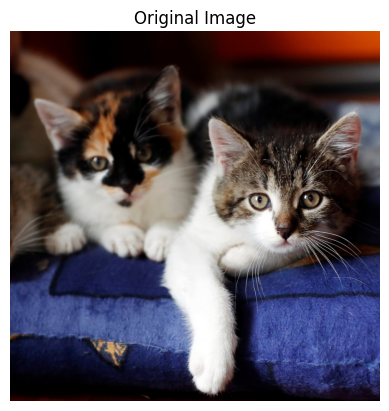

In [15]:
import matplotlib.pyplot as plt
import os
# Define the image path
#image_path_target = '/kaggle/input/catoos/cat_body.jpg'
image_path_target = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'

# Check if the file exists
if os.path.exists(image_path):
    print("Path exists!")
    # Load and display the image
    img = Image.open(image_path_target)
    print("Image size:", img.size)  # Print the size of the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title("Original Image")
    plt.show()
else:
    print("Path does not exist.")


In [16]:

prompt = None
controller_target = AttentionStore()  # Track attention maps
ddim_inversion = DDIM_Inversion(ldm_stable, controller=controller_target)

# Perform inversion
(image_gt, image_enc), x_t = ddim_inversion.invert(image_path_target, prompt, offsets=(0, 0, 0), verbose=True)


random
DDIM inversion...


## Accessing Queries and Keys 

In [17]:
# Access the stored queries and keys at specific timesteps
keys_queries_dict_target = controller_target.keys_queries_store

# Print available timesteps
print(keys_queries_dict_target.keys())  # Example: [0, 5, 10, ..., 45]

# Number of stored timesteps
print(f"Number of stored timesteps with keys/queries: {len(keys_queries_dict)}")

# Access keys and queries for a specific timestep (e.g., timestep 5)
timestep = 1
if timestep in keys_queries_dict_target:
    timestep_data = keys_queries_dict_target[timestep]
    
    # Print the keys (e.g., "down_self", "mid_self", "up_self")
    print(f"Available keys at timestep {timestep}: {timestep_data.keys()}")

    # Access specific keys and queries for "down_self"
    if "down_self" in timestep_data:
        down_self_data = timestep_data["down_self"]
        down_self_keys_target = down_self_data["keys"]  # List of stored key tensors
        down_self_queries_target = down_self_data["queries"]  # List of stored query tensors
        
        print(f"Number of keys stored for 'down_self' at timestep {timestep}: {len(down_self_keys_target)}")
        print(f"Number of queries stored for 'down_self' at timestep {timestep}: {len(down_self_queries_target)}")
        
        # Example: Inspect a specific key or query tensor
        print(f"Shape of the first key tensor for 'down_self': {down_self_keys_target[0].shape}")
        print(f"Shape of the first query tensor for 'down_self': {down_self_queries_target[0].shape}")


dict_keys([1])
Number of stored timesteps with keys/queries: 1
Available keys at timestep 1: dict_keys(['down_self', 'up_self'])
Number of keys stored for 'down_self' at timestep 1: 2
Number of queries stored for 'down_self' at timestep 1: 2
Shape of the first key tensor for 'down_self': torch.Size([8, 1024, 80])
Shape of the first query tensor for 'down_self': torch.Size([8, 1024, 80])


# Calculating Self-Attention for Both source and target image 

In [18]:
 import torch
import math

d_k = 32  # Dimension of keys/queries per head
res = 32  # Reshape resolution


In [19]:
# Slice keys and queries for target and source first
target_attention_key_1 = down_self_keys_target[0][4:]  # Slice first
target_attention_query_1 = down_self_queries_target[0][4:]
source_attention_key_1 = down_self_keys[0][4:]
source_attention_query_1 = down_self_queries[0][4:]

target_attention_key_2 = down_self_keys_target[1][4:]
target_attention_query_2 = down_self_queries_target[1][4:]
source_attention_key_2 = down_self_keys[1][4:]
source_attention_query_2 = down_self_queries[1][4:]

In [20]:
# Compute self-attention for source and target
scores_source_1 = torch.matmul(source_attention_query_1, source_attention_key_1.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [4, 1024, 1024]
attention_source_1 = torch.softmax(scores_source_1, dim=-1)  # Softmax over the last dimension
summed_attention_source_1 = attention_source_1.sum(dim=0)  # Summing along the heads immediately
#summed_attention_source_1 = attention_source_1.mean(dim=0)  # Averaging across heads


scores_source_2 = torch.matmul(source_attention_query_2, source_attention_key_2.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [4, 1024, 1024]
attention_source_2 = torch.softmax(scores_source_2, dim=-1)  # Softmax over the last dimension
summed_attention_source_2 = attention_source_2.sum(dim=0)  # Summing along the heads immediately
summed_attention_source_2 = attention_source_2.mean(dim=0)

In [21]:
# Aggregate the attention maps
aggregated_maps_source = []

reshaped_attention_source_1 = summed_attention_source_1.view(res, res, res, res).clone().detach()
reshaped_attention_source_1 /= reshaped_attention_source_1.sum(dim=(2, 3), keepdim=True)
aggregated_maps_source.append(reshaped_attention_source_1)

reshaped_attention_source_2 = summed_attention_source_2.view(res, res, res, res).clone().detach()
reshaped_attention_source_2 /= reshaped_attention_source_2.sum(dim=(2, 3), keepdim=True)
aggregated_maps_source.append(reshaped_attention_source_2)


# Compute averaged maps
aggregated_tensor_source = torch.stack(aggregated_maps_source, dim=0)
averaged_map_source = aggregated_tensor_source.mean(dim=0)



# Print resulting shapes for verification
print("averaged_map_source", averaged_map_source.shape)


averaged_map_source torch.Size([32, 32, 32, 32])


In [22]:
# Compute self-attention for source and target
scores_target_1 = torch.matmul(target_attention_query_1, target_attention_key_1.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [4, 1024, 1024]
attention_target_1 = torch.softmax(scores_target_1, dim=-1)  # Softmax over the last dimension
summed_attention_target_1 = attention_target_1.sum(dim=0)  # Summing along the heads immediately
#summed_attention_source_1 = attention_source_1.mean(dim=0)  # Averaging across heads


scores_target_2 = torch.matmul(target_attention_query_2, target_attention_key_2.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [4, 1024, 1024]
attention_target_2 = torch.softmax(scores_target_2, dim=-1)  # Softmax over the last dimension
summed_attention_target_2 = attention_target_2.sum(dim=0)  # Summing along the heads immediately
summed_attention_target_2 = attention_target_2.mean(dim=0)

aggregated_maps_target = []

reshaped_attention_target_1 = summed_attention_target_1.view(res, res, res, res).clone().detach()
reshaped_attention_target_1 /= reshaped_attention_target_1.sum(dim=(2, 3), keepdim=True)
aggregated_maps_target.append(reshaped_attention_target_1)

reshaped_attention_target_2 = summed_attention_target_2.view(res, res, res, res).clone().detach()
reshaped_attention_target_2 /= reshaped_attention_target_2.sum(dim=(2, 3), keepdim=True)
aggregated_maps_target.append(reshaped_attention_target_2)


# Compute averaged maps
aggregated_tensor_target = torch.stack(aggregated_maps_target, dim=0)
averaged_map_target = aggregated_tensor_target.mean(dim=0)




# Cross-Attention keys 

In [23]:
# Slice keys and queries for target and source first
target_attention_key_1 = down_self_keys_target[0][4:]  # Slice first
target_attention_query_1 = down_self_queries_target[0][4:]
source_attention_key_1 = down_self_keys[0][4:]
source_attention_query_1 = down_self_queries[0][4:]

target_attention_key_2 = down_self_keys_target[1][4:]
target_attention_query_2 = down_self_queries_target[1][4:]
source_attention_key_2 = down_self_keys[1][4:]
source_attention_query_2 = down_self_queries[1][4:]

In [24]:
def match_distribution(target, source):
    """Transforms target tensor to have the same mean and std as source."""
    mean_target = target.mean(dim=-1, keepdim=True)
    std_target = target.std(dim=-1, keepdim=True)

    mean_source = source.mean(dim=-1, keepdim=True)
    std_source = source.std(dim=-1, keepdim=True)

    transformed_target = ((target - mean_target) / (std_target + 1e-6)) * std_source + mean_source
    return transformed_target

target_attention_key_1_matched = match_distribution(target_attention_key_1, source_attention_query_1)
target_attention_key_2_matched = match_distribution(target_attention_key_2, source_attention_query_2)

source_attention_key_1_matched = match_distribution(source_attention_key_1, target_attention_query_1)
source_attention_key_2_matched = match_distribution(source_attention_key_2, target_attention_query_2)

In [25]:
import torch

def compute_stats(tensor, name):
    """
    Computes and prints the mean and standard deviation of a tensor.

    Parameters:
    - tensor (torch.Tensor): The input tensor.
    - name (str): Name of the tensor for printing.
    """
    mean_val = tensor.mean().item()
    std_val = tensor.std().item()
    print(f"{name} -> Mean: {mean_val:.6f}, Std Dev: {std_val:.6f}")
    return mean_val, std_val

# Compute statistics for each tensor
stats = {}

stats["target_attention_query_1"] = compute_stats(target_attention_query_1, "target_attention_query_1")
stats["source_attention_query_1"] = compute_stats(source_attention_query_1, "source_attention_query_1")

stats["target_attention_query_2"] = compute_stats(target_attention_query_2, "target_attention_query_2")
stats["source_attention_query_2"] = compute_stats(source_attention_query_2, "source_attention_query_2")


stats["source_attention_key_1"] = compute_stats(source_attention_key_1, "source_attention_key_1")
stats["target_attention_key_1"] = compute_stats(target_attention_key_1, "target_attention_key_1")
stats["target_attention_key_1_matched"] = compute_stats(target_attention_key_1_matched, "target_attention_key_1_matched")

stats["source_attention_key_2"] = compute_stats(source_attention_key_2, "source_attention_key_2")
stats["target_attention_key_2"] = compute_stats(target_attention_key_2, "target_attention_key_2")
stats["target_attention_key_2_matched"] = compute_stats(target_attention_key_2_matched, "target_attention_key_2_matched")

target_attention_query_1 -> Mean: 0.002866, Std Dev: 0.957563
source_attention_query_1 -> Mean: 0.014241, Std Dev: 0.925879
target_attention_query_2 -> Mean: -0.004477, Std Dev: 0.979361
source_attention_query_2 -> Mean: -0.013149, Std Dev: 0.956598
source_attention_key_1 -> Mean: 0.037312, Std Dev: 0.970300
target_attention_key_1 -> Mean: 0.023026, Std Dev: 1.032960
target_attention_key_1_matched -> Mean: 0.014241, Std Dev: 0.925878
source_attention_key_2 -> Mean: -0.051635, Std Dev: 1.034304
target_attention_key_2 -> Mean: -0.048862, Std Dev: 1.083334
target_attention_key_2_matched -> Mean: -0.013149, Std Dev: 0.956597


In [26]:
source_to_target_1 = torch.matmul(source_attention_query_1, target_attention_key_1.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [8, 1024, 1024]
attention_source_to_target_1 = torch.softmax(source_to_target_1, dim=-1)  # Softmax over the last dimension

target_to_source_1 = torch.matmul(target_attention_query_1, source_attention_key_1.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [8, 1024, 1024]
attention_target_to_source_1 = torch.softmax(target_to_source_1, dim=-1)  # Softmax over the last dimension

source_to_target_2 = torch.matmul(source_attention_query_2, target_attention_key_2.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [8, 1024, 1024]
attention_source_to_target_2 = torch.softmax(source_to_target_2, dim=-1)  # Softmax over the last dimension

target_to_source_2 = torch.matmul(target_attention_query_2, source_attention_key_2.transpose(-2, -1)) / math.sqrt(d_k)  # Shape: [8, 1024, 1024]
attention_target_to_source_2 = torch.softmax(target_to_source_2, dim=-1)  # Softmax over the last dimension

In [27]:
res = 32 

aggregated_maps_source_to_target = []
aggregated_maps_target_to_source = []


reshaped_map_source_to_target_1 = attention_source_to_target_1.view(attention_source_to_target_1.size(0), res, res, res, res).clone().detach()
reshaped_map_source_to_target_1 = reshaped_map_source_to_target_1.sum(dim=0)
reshaped_map_source_to_target_1 /= reshaped_map_source_to_target_1.sum(dim=(2, 3), keepdim=True)
aggregated_maps_source_to_target.append(reshaped_map_source_to_target_1)

reshaped_map_source_to_target_2 = attention_source_to_target_2.view(attention_source_to_target_2.size(0), res, res, res, res).clone().detach()
reshaped_map_source_to_target_2 = reshaped_map_source_to_target_2.sum(dim=0)
reshaped_map_source_to_target_2 /= reshaped_map_source_to_target_2.sum(dim=(2, 3), keepdim=True)
aggregated_maps_source_to_target.append(reshaped_map_source_to_target_2)



reshaped_map_target_to_source_1 = attention_target_to_source_1.view(attention_target_to_source_1.size(0), res, res, res, res).clone().detach()
reshaped_map_target_to_source_1 = reshaped_map_target_to_source_1.sum(dim=0)
reshaped_map_target_to_source_1 /= reshaped_map_target_to_source_1.sum(dim=(2, 3), keepdim=True)
aggregated_maps_target_to_source.append(reshaped_map_target_to_source_1)


reshaped_map_target_to_source_2 = attention_target_to_source_2.view(attention_target_to_source_2.size(0), res, res, res, res).clone().detach()
reshaped_map_target_to_source_2 = reshaped_map_target_to_source_2.sum(dim=0)
reshaped_map_target_to_source_2 /= reshaped_map_target_to_source_2.sum(dim=(2, 3), keepdim=True)
aggregated_maps_target_to_source.append(reshaped_map_target_to_source_2)



aggregated_tensor_source_to_target = torch.stack(aggregated_maps_source_to_target, dim=0)
averaged_map_source_to_target = aggregated_tensor_source_to_target.mean(dim=0)

aggregated_tensor_target_to_source = torch.stack(aggregated_maps_target_to_source, dim=0)
averaged_map_target_to_source = aggregated_tensor_target_to_source.mean(dim=0)


# Print resulting shapes for verification

print("averaged_map", averaged_map_target_to_source.shape)

averaged_map torch.Size([32, 32, 32, 32])


In [28]:
import torch
import math

# Define the temperature parameter (values < 1 sharpen attention)
temperature = 0.7

# Compute Source-to-Target Attention with Temperature Scaling
source_to_target_1_matched = torch.matmul(source_attention_query_1, target_attention_key_1_matched.transpose(-2, -1)) / math.sqrt(d_k)
attention_source_to_target_1_matched = torch.softmax(source_to_target_1_matched / temperature, dim=-1)  # Apply temperature scaling

source_to_target_2_matched = torch.matmul(source_attention_query_2, target_attention_key_2_matched.transpose(-2, -1)) / math.sqrt(d_k)
attention_source_to_target_2_matched = torch.softmax(source_to_target_2_matched / temperature, dim=-1)  # Apply temperature scaling

# Aggregate Maps (Source-to-Target)
aggregated_maps_source_to_target_matched = []

reshaped_map_source_to_target_1_matched = attention_source_to_target_1_matched.view(attention_source_to_target_1_matched.size(0), res, res, res, res).clone().detach()
reshaped_map_source_to_target_1_matched = reshaped_map_source_to_target_1_matched.sum(dim=0)
reshaped_map_source_to_target_1_matched /= reshaped_map_source_to_target_1_matched.sum(dim=(2, 3), keepdim=True)
aggregated_maps_source_to_target_matched.append(reshaped_map_source_to_target_1_matched)

reshaped_map_source_to_target_2_matched = attention_source_to_target_2_matched.view(attention_source_to_target_2_matched.size(0), res, res, res, res).clone().detach()
reshaped_map_source_to_target_2_matched = reshaped_map_source_to_target_2_matched.sum(dim=0)
reshaped_map_source_to_target_2_matched /= reshaped_map_source_to_target_2_matched.sum(dim=(2, 3), keepdim=True)
aggregated_maps_source_to_target_matched.append(reshaped_map_source_to_target_2_matched)

aggregated_maps_source_to_target_matched = torch.stack(aggregated_maps_source_to_target_matched, dim=0)
averaged_map_source_to_target_matched = aggregated_maps_source_to_target_matched.mean(dim=0)

# Compute Target-to-Source Attention with Temperature Scaling
target_to_source_1_matched = torch.matmul(target_attention_query_1, source_attention_key_1_matched.transpose(-2, -1)) / math.sqrt(d_k)
attention_target_to_source_1_matched = torch.softmax(target_to_source_1_matched / temperature, dim=-1)  # Apply temperature scaling

target_to_source_2_matched = torch.matmul(target_attention_query_2, source_attention_key_2_matched.transpose(-2, -1)) / math.sqrt(d_k)
attention_target_to_source_2_matched = torch.softmax(target_to_source_2_matched / temperature, dim=-1)  # Apply temperature scaling

# Aggregate Maps (Target-to-Source)
aggregated_maps_target_to_source_matched = []

reshaped_map_target_to_source_1_matched = attention_target_to_source_1_matched.view(attention_target_to_source_1_matched.size(0), res, res, res, res).clone().detach()
reshaped_map_target_to_source_1_matched = reshaped_map_target_to_source_1_matched.sum(dim=0)
reshaped_map_target_to_source_1_matched /= reshaped_map_target_to_source_1_matched.sum(dim=(2, 3), keepdim=True)
aggregated_maps_target_to_source_matched.append(reshaped_map_target_to_source_1_matched)

reshaped_map_target_to_source_2_matched = attention_target_to_source_2_matched.view(attention_target_to_source_2_matched.size(0), res, res, res, res).clone().detach()
reshaped_map_target_to_source_2_matched = reshaped_map_target_to_source_2_matched.sum(dim=0)
reshaped_map_target_to_source_2_matched /= reshaped_map_target_to_source_2_matched.sum(dim=(2, 3), keepdim=True)
aggregated_maps_target_to_source_matched.append(reshaped_map_target_to_source_2_matched)

aggregated_maps_target_to_source_matched = torch.stack(aggregated_maps_target_to_source_matched, dim=0)
averaged_map_target_to_source_matched = aggregated_maps_target_to_source_matched.mean(dim=0)


# Entire Pass with nearest neighbors 

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def get_neighbors(i, j, shape):
    """
    Returns the 8-connected neighbors of (i, j) within the given shape.
    """
    neighbors = [(i + di, j + dj) for di in [-1, 0, 1] for dj in [-1, 0, 1] if not (di == 0 and dj == 0)]
    return [(x, y) for x, y in neighbors if 0 <= x < shape[0] and 0 <= y < shape[1]]

def KL(x, Y):
    """
    Computes symmetric KL divergence between x and Y.
    """
    quotient = torch.log(x) - torch.log(Y)
    kl_1 = (x * quotient).sum(dim=(-2, -1)) / 2
    kl_2 = -(Y * quotient).sum(dim=(-2, -1)) / 2
    return kl_1 + kl_2

def visualize_attention_slices_with_KL(attention_source, attention_source_to_target, attention_target_to_source, slices_to_visualize):
    """
    Visualizes attention slices side-by-side, computes KL divergence, and stores full attention paths.
    """
    num_slices = len(slices_to_visualize)
    num_cols = 1 + 2 * 8  # (1 source + 8 source-to-target + 8 target-to-source)
    
    fig, axes = plt.subplots(num_slices, num_cols, figsize=(3 * num_cols, 3 * num_slices))
    
    if num_slices == 1:
        axes = np.expand_dims(axes, axis=0)
    
    argmax_dict = {}
    kl_dict = {}
    trace_dict = {}
    
    for row_idx, (i, j) in enumerate(slices_to_visualize):
        source_slice = attention_source[i, j, :, :].cpu()
        neighbors = get_neighbors(i, j, attention_source.shape[:2])
        argmax_dict[(i, j)] = neighbors
        trace_dict[(i, j)] = []
        kl_dict[(i, j)] = {"D_KL(Tgt→Src[Ref] || Tgt→Src[x, y])": {}, "D_KL(Tgt→Src[x, y] || Source)": {}}

        ax_source = axes[row_idx, 0]
        im_source = ax_source.imshow(source_slice.numpy(), cmap='viridis')
        ax_source.set_title(f"Source[{i}, {j}]")
        fig.colorbar(im_source, ax=ax_source, fraction=0.046, pad=0.04)
        
        target_argmax_coords = []
        for k_idx, (x_src, y_src) in enumerate(neighbors):
            source_to_target_slice = attention_source_to_target[x_src, y_src, :, :].cpu()
            flat_index = torch.argmax(source_to_target_slice).item()
            x_src_trg, y_src_trg = np.unravel_index(flat_index, source_to_target_slice.shape)
            target_argmax_coords.append((x_src_trg, y_src_trg))
            
            ax_target = axes[row_idx, k_idx + 1]
            im_target = ax_target.imshow(source_to_target_slice.numpy(), cmap='viridis')
            ax_target.scatter(y_src_trg, x_src_trg, color='red', marker='x', s=50)
            ax_target.set_title(f"Src→Tgt[{x_src}, {y_src}]")
            fig.colorbar(im_target, ax=ax_target, fraction=0.046, pad=0.04)
        
        max_target_to_source_slice = attention_target_to_source[target_argmax_coords[0][0], target_argmax_coords[0][1], :, :].cpu()
        
        for k_idx, (x_src_trg, y_src_trg) in enumerate(target_argmax_coords):
            target_to_source_slice = attention_target_to_source[x_src_trg, y_src_trg, :, :].cpu()
            flat_index = torch.argmax(target_to_source_slice).item()
            x_trg_src, y_trg_src = np.unravel_index(flat_index, target_to_source_slice.shape)
            trace_dict[(i, j)].append(((neighbors[k_idx]), (x_src_trg, y_src_trg), (x_trg_src, y_trg_src)))
            kl_value_ref_tgt = KL(max_target_to_source_slice, target_to_source_slice).item()
            kl_dict[(i, j)]["D_KL(Tgt→Src[Ref] || Tgt→Src[x, y])"][(x_src_trg, y_src_trg)] = kl_value_ref_tgt
            kl_value_tgt_src = KL(target_to_source_slice, source_slice).item()
            kl_dict[(i, j)]["D_KL(Tgt→Src[x, y] || Source)"][(x_src_trg, y_src_trg)] = kl_value_tgt_src
            
            ax_final = axes[row_idx, 8 + k_idx + 1]
            im_final = ax_final.imshow(target_to_source_slice.numpy(), cmap='viridis')
            ax_final.scatter(y_trg_src, x_trg_src, color='yellow', marker='x', s=50)
            ax_final.set_title(f"Tgt→Src[{x_src_trg}, {y_src_trg}]")
            fig.colorbar(im_final, ax=ax_final, fraction=0.046, pad=0.04)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.tight_layout(pad=0.5)
    plt.show()
    
    return argmax_dict, kl_dict, trace_dict

"""
slices_to_visualize = [(5, 20), (5, 21), (5, 22),(5,23),(4,20),(4,21),(4,22),
                      (8,28),(8,29),(8,27),(7,27),(9,28),
                      (8,9),(8,10),(7,9),
                      (30,11),(30,12),(30,13),(29,13)]

"""

# Example usage
slices_to_visualize = [(10, 20), (9, 24), (2, 10)]

"""
argmax_results = visualize_attention_slices_with_KL(
    averaged_map_source, 
    averaged_map_source_to_target, 
    averaged_map_target_to_source, 
    slices_to_visualize
)
"""




'\nargmax_results = visualize_attention_slices_with_KL(\n    averaged_map_source, \n    averaged_map_source_to_target, \n    averaged_map_target_to_source, \n    slices_to_visualize\n)\n'

In [30]:
import torch
import numpy as np

def get_neighbors_including_self(i, j, shape):
    """
    Returns the 8-connected neighbors of (i, j) including itself within the given shape.
    """
    neighbors = [(i + di, j + dj) for di in [-1, 0, 1] for dj in [-1, 0, 1]]
    return [(x, y) for x, y in neighbors if 0 <= x < shape[0] and 0 <= y < shape[1]]

def KL(x, Y):
    """
    Computes symmetric KL divergence between x and Y.
    """
    quotient = torch.log(x) - torch.log(Y)
    kl_1 = (x * quotient).sum(dim=(-2, -1)) / 2
    kl_2 = -(Y * quotient).sum(dim=(-2, -1)) / 2
    return kl_1 + kl_2

def entire_pass(attention_source, attention_source_to_target, attention_target_to_source, slices_to_visualize):
    """
    Computes KL divergence and stores full attention paths using neighboring points and the point itself.
    """
    argmax_dict = {}
    kl_dict = {}
    trace_dict = {}
    
    for row_idx, (i, j) in enumerate(slices_to_visualize):
        source_slice = attention_source[i, j, :, :].cpu()
        neighbors = get_neighbors_including_self(i, j, attention_source.shape[:2])
        argmax_dict[(i, j)] = neighbors
        trace_dict[(i, j)] = []
        kl_dict[(i, j)] = {"D_KL(Tgt→Src[Ref] || Tgt→Src[x, y])": {}, "D_KL(Tgt→Src[x, y] || Source)": {}}

        target_argmax_coords = []
        for k_idx, (x_src, y_src) in enumerate(neighbors):
            source_to_target_slice = attention_source_to_target[x_src, y_src, :, :].cpu()
            flat_index = torch.argmax(source_to_target_slice).item()
            x_src_trg, y_src_trg = np.unravel_index(flat_index, source_to_target_slice.shape)
            target_argmax_coords.append((x_src_trg, y_src_trg))

        max_target_to_source_slice = attention_target_to_source[target_argmax_coords[0][0], target_argmax_coords[0][1], :, :].cpu()
        
        for k_idx, (x_src_trg, y_src_trg) in enumerate(target_argmax_coords):
            target_to_source_slice = attention_target_to_source[x_src_trg, y_src_trg, :, :].cpu()
            flat_index = torch.argmax(target_to_source_slice).item()
            x_trg_src, y_trg_src = np.unravel_index(flat_index, target_to_source_slice.shape)
            trace_dict[(i, j)].append(((neighbors[k_idx]), (x_src_trg, y_src_trg), (x_trg_src, y_trg_src)))
            kl_value_ref_tgt = KL(max_target_to_source_slice, target_to_source_slice).item()
            kl_dict[(i, j)]["D_KL(Tgt→Src[Ref] || Tgt→Src[x, y])"][(x_src_trg, y_src_trg)] = kl_value_ref_tgt
            kl_value_tgt_src = KL(target_to_source_slice, source_slice).item()
            kl_dict[(i, j)]["D_KL(Tgt→Src[x, y] || Source)"][(x_src_trg, y_src_trg)] = kl_value_tgt_src
    
    return argmax_dict, kl_dict, trace_dict

In [31]:
#slices_of_interest = [(3,i) for i in range(32)]

"""
slices_of_interest = [(5, 20), (5, 21), (5, 22),(5,23),(4,20),(4,21),(4,22),
                      (8,28),(8,29),(8,27),(7,27),(9,28),
                      (8,9),(8,10),(7,9),
                      (30,11),(30,12),(30,13),(29,13)]

"""

dataset = [(i,j) for i in range(32) for j in range(32)]

argmax_results, kl_dict, trace_results = entire_pass(
    averaged_map_source, 
    averaged_map_source_to_target, 
    averaged_map_target_to_source, 
    dataset
)



In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

def visualize_trace_on_grid_with_coordinates(trace_results, source_image_path, target_image_path):
    """
    Visualizes trace results on:
    1. A 32x32 grid overlaid on images with arrows showing the mapping of points.
    2. A separate 32x32 coordinate grid where crosses are shown exactly at their grid positions.
    
    - First row: Images (Source, Intermediate, Final)
    - Second row: 32x32 Grid Representations
    """
    # Load and resize images to 320x320 (to match 32x32 grid with 10-pixel spacing)
    img_size = 320
    grid_size = 32
    cell_size = img_size // grid_size  # 10 pixels per grid cell

    source_img = cv2.cvtColor(cv2.resize(cv2.imread(source_image_path), (img_size, img_size)), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.resize(cv2.imread(target_image_path), (img_size, img_size)), cv2.COLOR_BGR2RGB)

    cmap = cm.get_cmap("tab10")  # Colormap for distinct colors

    for key, traces in trace_results.items():
        # Convert traces into NumPy arrays for efficient indexing
        src_coords = np.array([src for src, _, _ in traces])
        inter_coords = np.array([src_trg for _, src_trg, _ in traces])
        trg_coords = np.array([trg_src for _, _, trg_src in traces])

        # Get unique points and assign colors
        all_coords = np.vstack((src_coords, inter_coords, trg_coords))
        unique_points, indices = np.unique(all_coords, axis=0, return_inverse=True)
        colors = [cmap(i % 10) for i in indices]  # Assign a color per unique point

        # Create a 2-row visualization layout with increased figure size
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        titles = [f"Source [{key[0]}, {key[1]}]", "Intermediate (Target)", "Final (Back to Source)"]
        images = [source_img, target_img, source_img]
        coords_list = [src_coords, inter_coords, trg_coords]

        for row in range(2):  # First row = Images, Second row = Grid
            for col, (ax, title, coords) in enumerate(zip(axes[row], titles, coords_list)):
                ax.set_title(title, fontsize=12)

                if row == 0:
                    # First row: Image with grid overlay
                    ax.imshow(images[col], alpha=0.3)  # Dim image for better visibility

                    # Overlay 32x32 grid with lighter lines
                    for i in range(grid_size + 1):
                        ax.axhline(i * cell_size, color='gray', linestyle='--', linewidth=0.3, alpha=0.7)
                        ax.axvline(i * cell_size, color='gray', linestyle='--', linewidth=0.3, alpha=0.7)

                    # Scatter points ensuring alignment with the grid
                    if coords.size:
                        for i, (y, x) in enumerate(coords):
                            px_x, px_y = x * cell_size + cell_size // 2, y * cell_size + cell_size // 2
                            ax.scatter(px_x, px_y, color=colors[i], s=50, marker='x')

                else:
                    # Second row: 32x32 grid with improved spacing
                    ax.set_xlim(-1, grid_size)  # Add margin
                    ax.set_ylim(grid_size, -1)  # Flip y-axis for correct alignment
                    ax.set_xticks(np.arange(0, grid_size, 4))  # Show fewer x ticks
                    ax.set_yticks(np.arange(0, grid_size, 4))  # Show fewer y ticks
                    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Light grid

                    # Scatter points with corrected (x, y) placement
                    if coords.size:
                        for i, (y, x) in enumerate(coords):
                            ax.scatter(x, y, color=colors[i], s=50, marker='x')

        plt.tight_layout()
        plt.show()



# MSE Loss 

For now, we use MSE loss to quantify $d(x_s,x_s'$. Keep in mind that we also have KL divergence at our disposal. However, it is not quite clear to me for now how exactly I can apply that. 

In [33]:
def compute_mse(trace_results):
    mse_results = {}
    
    for key, traces in trace_results.items():
        errors = []
        for src, _, trg_src in traces:
            mse = np.mean((np.array(src) - np.array(trg_src)) ** 2)
            errors.append(mse)
        
        mse_results[key] = errors
    
    return mse_results


In [34]:
mse_results = compute_mse(trace_results)


# Organzing the Data in PD frame 

In [35]:
import pandas as pd

# Function to organize trace results, MSE values, and KL divergence into a structured DataFrame
def organize_results(trace_results, mse_results, kl_dict):
    data = []

    for key, traces in trace_results.items():
        for idx, (src, src_trg, trg_src) in enumerate(traces):
            mse_value = mse_results[key][idx] if key in mse_results and idx < len(mse_results[key]) else None

            kl_ref_tgt = kl_dict[key]["D_KL(Tgt→Src[Ref] || Tgt→Src[x, y])"].get(src_trg, None)
            kl_tgt_src = kl_dict[key]["D_KL(Tgt→Src[x, y] || Source)"].get(src_trg, None)

            data.append({
                "Source": key,
                "Step 1 (Src)": src,
                "Step 2 (Src → Tgt)": src_trg,
                "Step 3 (Tgt → Src)": trg_src,
                "MSE (Src vs. Tgt→Src)": mse_value,
                "KL (Ref || Tgt→Src)": kl_ref_tgt,
                "KL (Tgt→Src || Src)": kl_tgt_src
            })

    df = pd.DataFrame(data)
    return df

# Organizing results into a DataFrame
organized_df = organize_results(trace_results, mse_results, kl_dict)


In [36]:
from IPython.display import display
#display(organized_df)

# Computing MD

There are two different approaches we can take here. We can compute MD globally or MD locally. Firstly, let us consider the evaluation of MD globally. This tells us which points are most frequently mapped to overall in the dataset.  This would be useful for detecting large-scale feature collapses.  We will compute it as following: 
$$
MD_{\text{global}}(y) = \sum_{x_s \in \text{all source points}} 1(f(x_s) = y)
$$

However, MD might ignore localized collapse that only occur in specific regions. To mitigate this, we compute MD locally (Using Only Nearby Points). This tells us how many points in a local neighborhood map to the same region. This is computed as: 

$$
MD_{\text{local}}(y) = \sum_{x_s \in N(y)} 1(f(x_s) = y)
$$

where N(y) N(y)  is a small local neighborhood around y y . This will us Detect localized misalignment (e.g., distorted areas where multiple neighbors collapse to the same target).


In [37]:
# Convert coordinate strings to tuples (only if needed)
def parse_tuple(s):
    if isinstance(s, str):  # Only parse if it's a string
        return tuple(map(int, s.strip("()").split(", ")))
    return s  # If already a tuple, return as is

# Apply the function safely
organized_df["Step 1 (Src)"] = organized_df["Step 1 (Src)"].apply(parse_tuple)
organized_df["Step 2 (Src → Tgt)"] = organized_df["Step 2 (Src → Tgt)"].apply(parse_tuple)

# Initialize a 32x32 grid for Mapping Density (MD)
md_grid = np.zeros((32, 32), dtype=int)

# Count occurrences of each target point
for target in organized_df["Step 2 (Src → Tgt)"]:
    x, y = target  # Target coordinates
    md_grid[x, y] += 1  # Increment count

# Convert to a DataFrame for easy visualization
md_df = pd.DataFrame(md_grid)


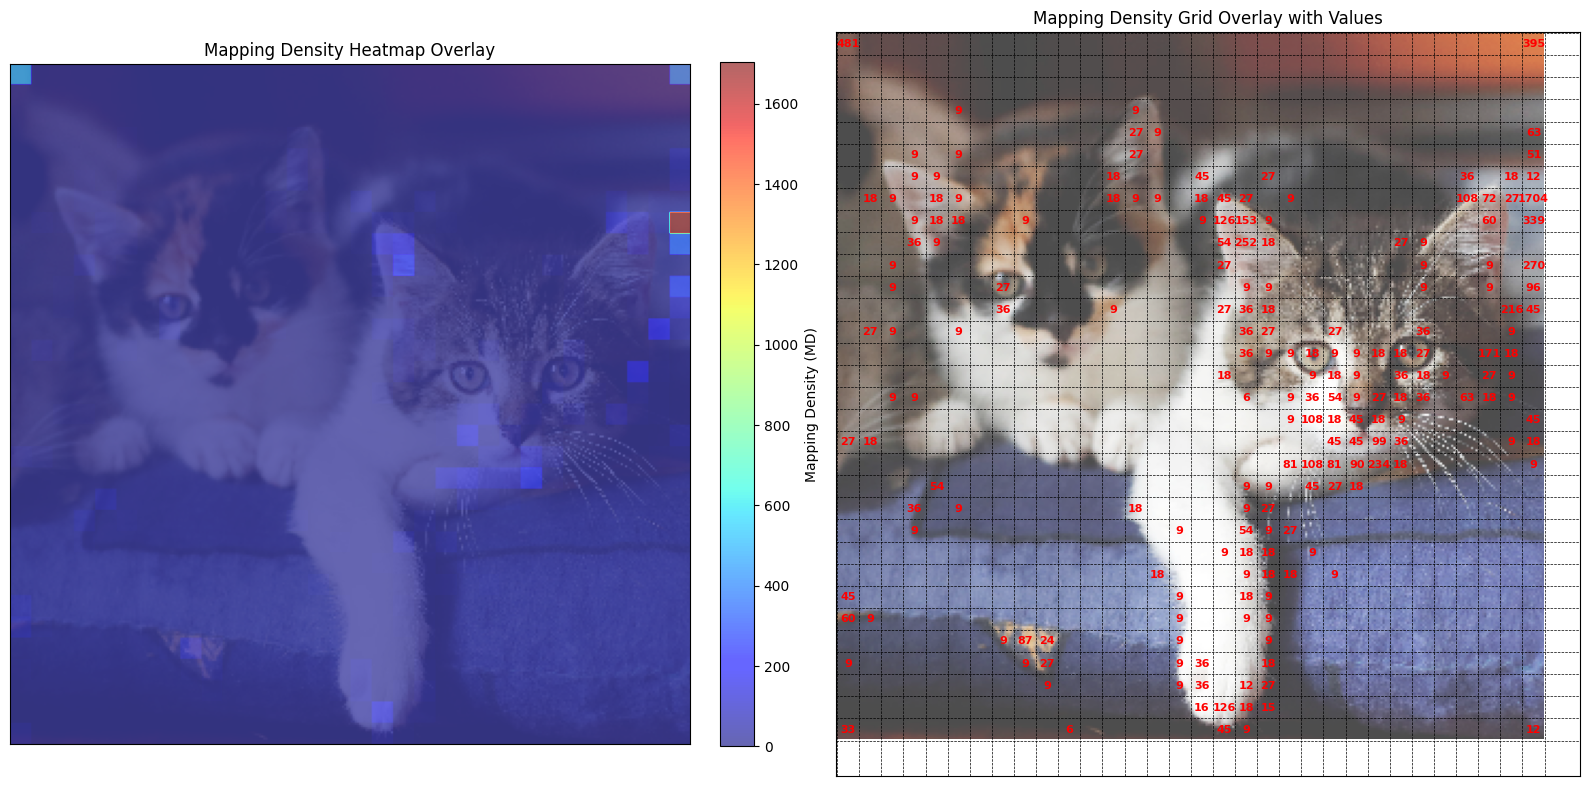

In [38]:
import matplotlib.colors as mcolors

# Create a side-by-side visualization: (1) Heatmap overlay (2) Numeric overlay on the image
target_img_path = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'
target_img = cv2.imread(image_path_target)
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB


# Resize image to match the 32x32 grid scale (assuming original is larger)
img_size = 320  # Example target size (adjust if needed)
grid_size = 32
cell_size = 320//32
target_img = cv2.resize(target_img, (img_size, img_size))

# Resize MD grid to match image size for overlaying
md_resized = cv2.resize(md_grid.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- First Plot: Heatmap Overlay ---
axes[0].imshow(target_img, alpha=0.5)  # Target image with transparency
heatmap = axes[0].imshow(md_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=md_grid.max()))

# Add color bar for heatmap
fig.colorbar(heatmap, ax=axes[0], fraction=0.046, pad=0.04, label="Mapping Density (MD)")

# Hide axis labels
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Mapping Density Heatmap Overlay")

# --- Second Plot: Numeric Grid Overlay ---
axes[1].imshow(target_img, alpha=0.7)  # Target image with transparency

# Overlay grid lines
for i in range(grid_size + 1):
    axes[1].axhline(i * cell_size, color='black', linestyle='--', linewidth=0.5)
    axes[1].axvline(i * cell_size, color='black', linestyle='--', linewidth=0.5)

# Overlay MD values at each grid cell's center
for i in range(grid_size):
    for j in range(grid_size):
        md_value = md_grid[i, j]
        if md_value > 0:  # Only show nonzero values
            axes[1].text(j * cell_size + cell_size // 2, 
                         i * cell_size + cell_size // 2, 
                         str(md_value), 
                         color="red", fontsize=8, ha="center", va="center", fontweight="bold")

# Remove axis ticks
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Mapping Density Grid Overlay with Values")

# Show the combined visualization
plt.tight_layout()
plt.show()

In [39]:
# Add Mapping Density (MD) column to organized_df
organized_df["Step 2 (Src → Tgt)"] = organized_df["Step 2 (Src → Tgt)"].apply(parse_tuple)
organized_df["MD Density"] = organized_df["Step 2 (Src → Tgt)"].apply(lambda coord: md_grid[coord[0], coord[1]])
#display(organized_df)



# Computing IME 

We now compute $P(S_{i}|T_j)$. If many sources map to one target with equal probability, entropy will be high. The closer IME is to zero, 
it would mean that one specific source is dominating the mapping and this mapping is clear and stable. 

In [40]:
import numpy as np
import pandas as pd

# Initialize a 32x32 grid for IME values
ime_grid = np.zeros((32, 32), dtype=float)

# Dictionary to store source counts per target point
mapping_counts = {}

# Step 1: Count occurrences of each (Src → Tgt) mapping
for _, row in organized_df.iterrows():
    source = row["Step 1 (Src)"]
    target = row["Step 2 (Src → Tgt)"]
    
    if target not in mapping_counts:
        mapping_counts[target] = {}
    if source not in mapping_counts[target]:
        mapping_counts[target][source] = 0
    
    mapping_counts[target][source] += 1

# Step 2: Compute probability distributions P(S_i | T_j)
mapping_probs = {}
for target, source_counts in mapping_counts.items():
    total_mappings = sum(source_counts.values())
    mapping_probs[target] = {src: count / total_mappings for src, count in source_counts.items()}

# Step 3: Compute entropy H(T_j) for each target
for target, prob_dist in mapping_probs.items():
    entropy = -sum(p * np.log(p + 1e-8) for p in prob_dist.values())  # Compute entropy
    x, y = target  # Extract grid coordinates
    ime_grid[x, y] = entropy  # Assign entropy value to the corresponding grid location

# Convert IME grid to a DataFrame for easier visualization
ime_df = pd.DataFrame(ime_grid)


In [41]:
# Computing statistics without considering zero values

nonzero_values = ime_df.values[ime_df.values > 0]
nonzero_mean = nonzero_values.mean()
nonzero_median = np.median(nonzero_values)
percentile_90 = np.percentile(nonzero_values, 90)
percentile_95 = np.percentile(nonzero_values, 95)
percentile_99 = np.percentile(nonzero_values, 99)

# Compute Interquartile Range (IQR) thresholding for nonzero values
Q1 = np.percentile(nonzero_values, 25)
Q3 = np.percentile(nonzero_values, 75)
IQR = Q3 - Q1
iqr_threshold = Q3 + 1.5 * IQR  # Outlier threshold

# Display computed thresholds
thresholds = {
    "Mean (Nonzero)": nonzero_mean,
    "Median (Nonzero)": nonzero_median,
    "90th Percentile": percentile_90,
    "95th Percentile": percentile_95,
    "99th Percentile": percentile_99,
    "IQR Threshold (Q3 + 1.5*IQR)": iqr_threshold
}

thresholds

{'Mean (Nonzero)': 1.4622673578349918,
 'Median (Nonzero)': 1.0986122586681102,
 '90th Percentile': 2.546566793718913,
 '95th Percentile': 3.272917868452259,
 '99th Percentile': 4.052585302654791,
 'IQR Threshold (Q3 + 1.5*IQR)': 3.4396777822302242}

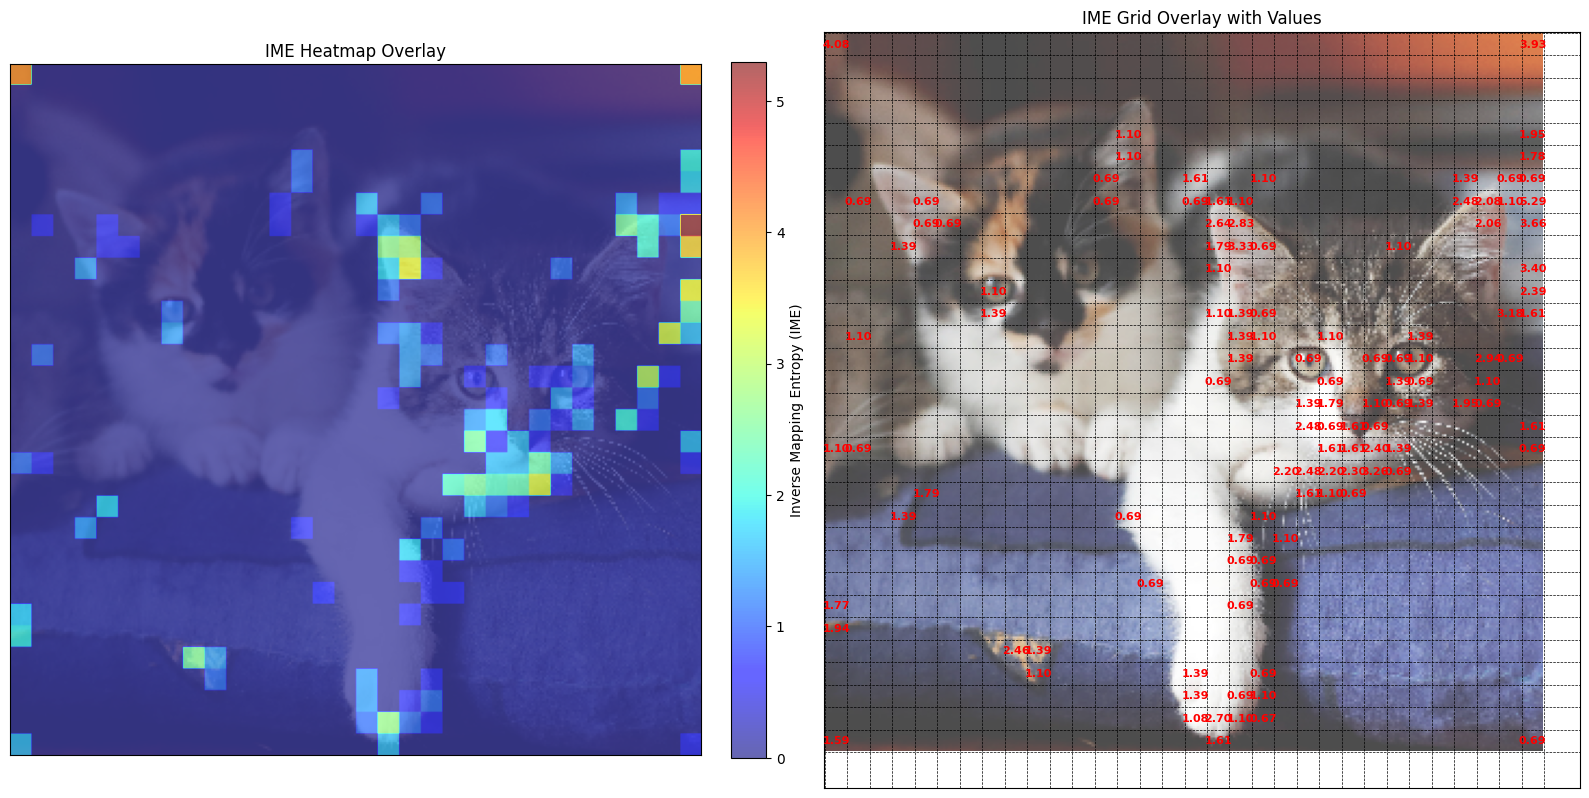

In [42]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the target image (assuming the user provides the correct path)
image_path_target = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'
target_img = cv2.imread(image_path_target)

# Check if image is successfully loaded
if target_img is not None:
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Resize image to match the 32x32 grid scale (assuming original is larger)
    img_size = 320  # Example target size (adjust if needed)
    target_img = cv2.resize(target_img, (img_size, img_size))

    # Resize IME grid to match image size for overlaying
    ime_resized = cv2.resize(ime_grid.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Create a side-by-side visualization: (1) Heatmap overlay (2) Numeric overlay on the image
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # --- First Plot: Heatmap Overlay ---
    axes[0].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[0].imshow(ime_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=ime_grid.max()))

    # Add color bar for heatmap
    fig.colorbar(heatmap, ax=axes[0], fraction=0.046, pad=0.04, label="Inverse Mapping Entropy (IME)")

    # Hide axis labels
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("IME Heatmap Overlay")

    # --- Second Plot: Numeric Grid Overlay ---
    axes[1].imshow(target_img, alpha=0.7)  # Target image with transparency

    # Overlay grid lines
    cell_size = img_size // grid_size
    for i in range(grid_size + 1):
        axes[1].axhline(i * cell_size, color='black', linestyle='--', linewidth=0.5)
        axes[1].axvline(i * cell_size, color='black', linestyle='--', linewidth=0.5)

    # Overlay IME values at each grid cell's center
    for i in range(grid_size):
        for j in range(grid_size):
            ime_value = ime_grid[i, j]
            if ime_value > 0:  # Only show nonzero values
                axes[1].text(j * cell_size + cell_size // 2,
                             i * cell_size + cell_size // 2,
                             f"{ime_value:.2f}",
                             color="red", fontsize=8, ha="center", va="center", fontweight="bold")

    # Remove axis ticks
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title("IME Grid Overlay with Values")

    # Show the combined visualization
    plt.tight_layout()
    plt.show()
else:
    print("Error: Target image not found. Please upload the correct image.")


In [43]:
# Add Inverse Mapping Entropy (IME) column to organized_df

organized_df["Step 2 (Src → Tgt)"] = organized_df["Step 2 (Src → Tgt)"].apply(parse_tuple)
organized_df["IME"] = organized_df["Step 2 (Src → Tgt)"].apply(lambda coord: ime_grid[coord[0], coord[1]])
organized_df["IME"] = organized_df["IME"].apply(lambda x: float(f"{x:.4f}"))  # Adjust decimal places as needed
display(organized_df)

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
0       (0, 0)       (0, 0)             (0, 0)            (0, 31)   
1       (0, 0)       (0, 1)            (7, 31)             (8, 7)   
2       (0, 0)       (1, 0)            (5, 31)            (0, 18)   
3       (0, 0)       (1, 1)            (5, 31)            (0, 18)   
4       (0, 1)       (0, 0)             (0, 0)            (0, 31)   
...        ...          ...                ...                ...   
8831  (31, 30)     (31, 31)           (30, 16)           (16, 25)   
8832  (31, 31)     (30, 30)           (30, 17)           (31, 31)   
8833  (31, 31)     (30, 31)           (30, 16)           (16, 25)   
8834  (31, 31)     (31, 30)           (30, 16)           (16, 25)   
8835  (31, 31)     (31, 31)           (30, 16)           (16, 25)   

      MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  \
0                     480.5             0.000000             1.438492   
1                      50.0             2.782383             1.409587   
2                     162.5             0.711206             1.080943   
3                     145.0             0.711206             1.080943   
4                     480.5             0.000000             1.793255   
...                     ...                  ...                  ...   
8831                  130.5             0.418011             1.077926   
8832                    1.0             0.000000             0.353772   
8833                  116.0             0.418011             0.696404   
8834                  125.0             0.418011             0.696404   
8835                  130.5             0.418011             0.696404   

      MD Density     IME  
0            481  4.0764  
1           1704  5.2935  
2             51  1.7823  
3             51  1.7823  
4            481  4.0764  
...          ...     ...  
8831          16  1.0822  
8832         126  2.6970  
8833          16  1.0822  
8834          16  1.0822  
8835          16  1.0822  

[8836 rows x 9 columns]

# Computing NIMS

In [44]:
# Initialize a 32x32 grid for NIMS values
nims_grid = np.zeros((32, 32), dtype=float)

# Compute NIMS for each target coordinate using the formula: NIMS(y) = IME(y) / log(MD(y))
for i in range(32):
    for j in range(32):
        md_value = md_grid[i, j]  # Mapping Density
        ime_value = ime_grid[i, j]  # IME

        # Ensure no division by zero; if MD is too low, return just IME
        if md_value > 1:
            nims_grid[i, j] = ime_value / np.log(md_value)
        else:
            nims_grid[i, j] = ime_value  # If MD is too low, return IME directly

# Convert NIMS grid to a DataFrame for easier visualization
nims_df = pd.DataFrame(nims_grid)


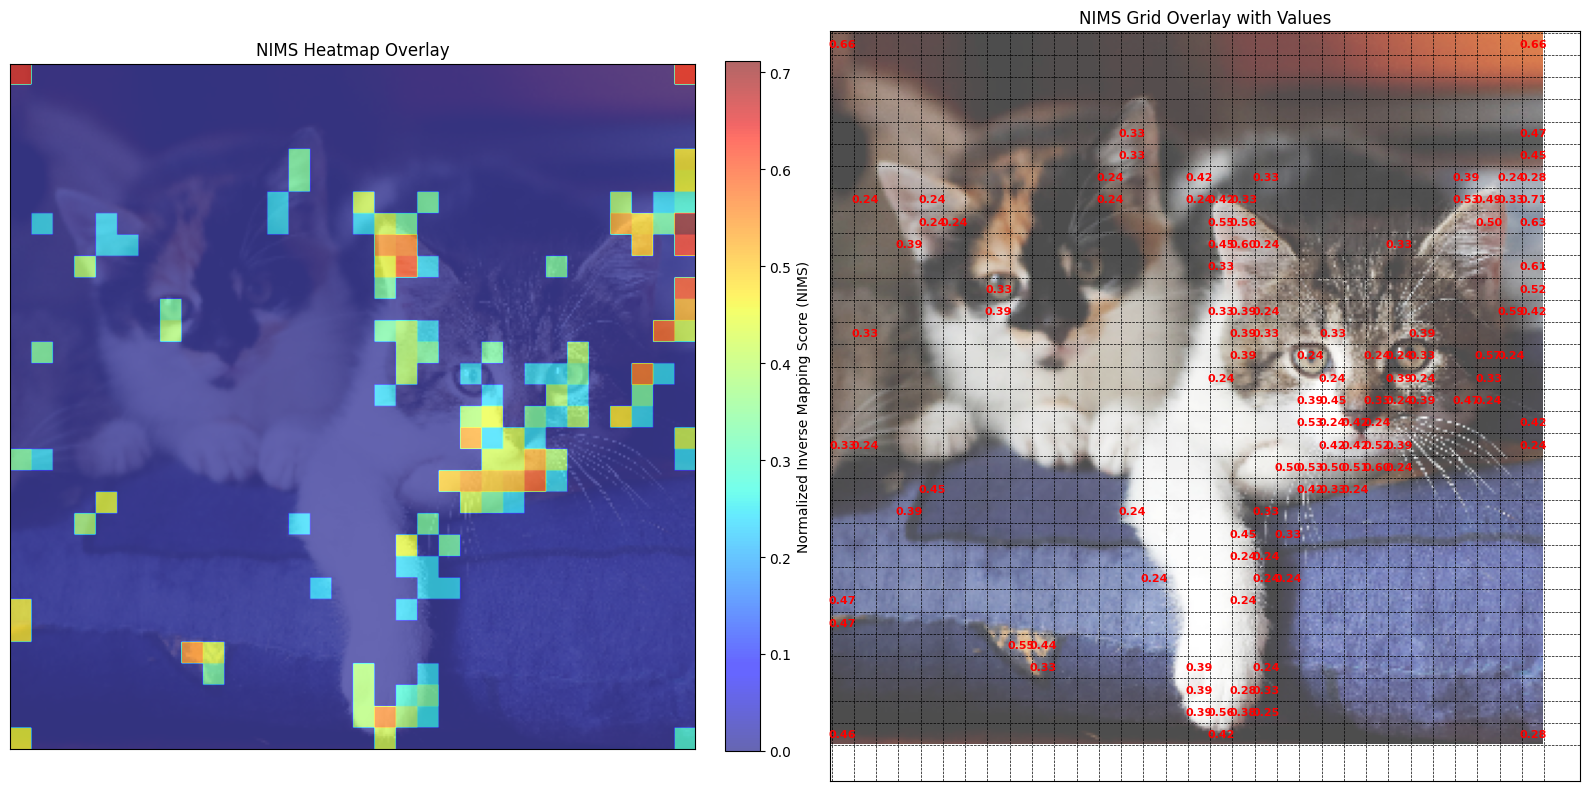

In [45]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the target image (ensure the correct path is provided)
image_path_target = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'
target_img = cv2.imread(image_path_target)

# Check if image is successfully loaded
if target_img is not None:
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Resize image to match the 32x32 grid scale (assuming original is larger)
    img_size = 320  # Example target size (adjust if needed)
    target_img = cv2.resize(target_img, (img_size, img_size))

    # Resize NIMS grid to match image size for overlaying
    nims_resized = cv2.resize(nims_grid.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Create a side-by-side visualization: (1) Heatmap overlay (2) Numeric overlay on the image
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # --- First Plot: Heatmap Overlay ---
    axes[0].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[0].imshow(nims_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=nims_grid.max()))

    # Add color bar for heatmap
    fig.colorbar(heatmap, ax=axes[0], fraction=0.046, pad=0.04, label="Normalized Inverse Mapping Score (NIMS)")

    # Hide axis labels
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("NIMS Heatmap Overlay")

    # --- Second Plot: Numeric Grid Overlay ---
    axes[1].imshow(target_img, alpha=0.7)  # Target image with transparency

    # Overlay grid lines
    cell_size = img_size // grid_size
    for i in range(grid_size + 1):
        axes[1].axhline(i * cell_size, color='black', linestyle='--', linewidth=0.5)
        axes[1].axvline(i * cell_size, color='black', linestyle='--', linewidth=0.5)

    # Overlay NIMS values at each grid cell's center
    for i in range(grid_size):
        for j in range(grid_size):
            nims_value = nims_grid[i, j]
            if nims_value > 0:  # Only show nonzero values
                axes[1].text(j * cell_size + cell_size // 2,
                             i * cell_size + cell_size // 2,
                             f"{nims_value:.2f}",
                             color="red", fontsize=8, ha="center", va="center", fontweight="bold")

    # Remove axis ticks
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title("NIMS Grid Overlay with Values")

    # Show the combined visualization
    plt.tight_layout()
    plt.show()
else:
    print("Error: Target image not found. Please upload the correct image.")


In [46]:
# Add NIMS (Normalized Inverse Mapping Score) column to organized_df

organized_df["Step 2 (Src → Tgt)"] = organized_df["Step 2 (Src → Tgt)"].apply(parse_tuple)
organized_df["NIMS"] = organized_df["Step 2 (Src → Tgt)"].apply(lambda coord: nims_grid[coord[0], coord[1]])
organized_df["NIMS"] = organized_df["NIMS"].apply(lambda x: float(f"{x:.4f}"))  # Adjust decimal places as needed

display(organized_df)

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
0       (0, 0)       (0, 0)             (0, 0)            (0, 31)   
1       (0, 0)       (0, 1)            (7, 31)             (8, 7)   
2       (0, 0)       (1, 0)            (5, 31)            (0, 18)   
3       (0, 0)       (1, 1)            (5, 31)            (0, 18)   
4       (0, 1)       (0, 0)             (0, 0)            (0, 31)   
...        ...          ...                ...                ...   
8831  (31, 30)     (31, 31)           (30, 16)           (16, 25)   
8832  (31, 31)     (30, 30)           (30, 17)           (31, 31)   
8833  (31, 31)     (30, 31)           (30, 16)           (16, 25)   
8834  (31, 31)     (31, 30)           (30, 16)           (16, 25)   
8835  (31, 31)     (31, 31)           (30, 16)           (16, 25)   

      MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  \
0                     480.5             0.000000             1.438492   
1                      50.0             2.782383             1.409587   
2                     162.5             0.711206             1.080943   
3                     145.0             0.711206             1.080943   
4                     480.5             0.000000             1.793255   
...                     ...                  ...                  ...   
8831                  130.5             0.418011             1.077926   
8832                    1.0             0.000000             0.353772   
8833                  116.0             0.418011             0.696404   
8834                  125.0             0.418011             0.696404   
8835                  130.5             0.418011             0.696404   

      MD Density     IME    NIMS  
0            481  4.0764  0.6601  
1           1704  5.2935  0.7114  
2             51  1.7823  0.4533  
3             51  1.7823  0.4533  
4            481  4.0764  0.6601  
...          ...     ...     ...  
8831          16  1.0822  0.3903  
8832         126  2.6970  0.5577  
8833          16  1.0822  0.3903  
8834          16  1.0822  0.3903  
8835          16  1.0822  0.3903  

[8836 rows x 10 columns]

# Side by Side visualization 

Text(0.5, 1.0, 'Mapping Density Heatmap Overlay')

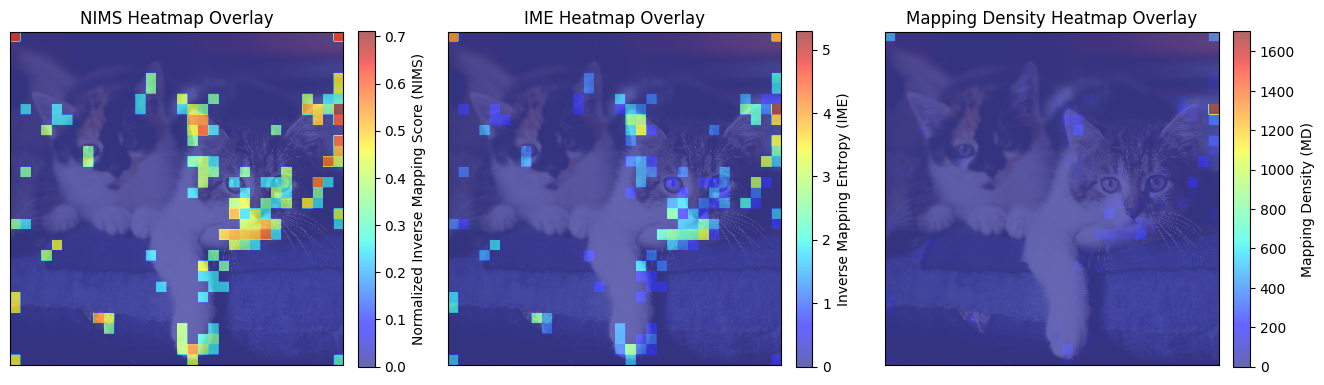

In [47]:
    # Resize NIMS grid to match image size for overlaying
    nims_resized = cv2.resize(nims_grid.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Create a side-by-side visualization: (1) Heatmap overlay (2) Numeric overlay on the image
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))

    # --- First Plot: Heatmap Overlay ---
    axes[0].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[0].imshow(nims_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=nims_grid.max()))

    # Add color bar for heatmap
    fig.colorbar(heatmap, ax=axes[0], fraction=0.046, pad=0.04, label="Normalized Inverse Mapping Score (NIMS)")

    # Hide axis labels
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("NIMS Heatmap Overlay")

    # --- Second Plot: Heatmap Overlay ---
    axes[1].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[1].imshow(ime_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=ime_grid.max()))
    fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04, label="Inverse Mapping Entropy (IME)")

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title("IME Heatmap Overlay")

    # --- Third Plot: Heatmap Overlay ---
    axes[2].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[2].imshow(md_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=md_grid.max()))
    
    fig.colorbar(heatmap, ax=axes[2], fraction=0.046, pad=0.04, label="Mapping Density (MD)")
    
    # Hide axis labels
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title("Mapping Density Heatmap Overlay")


In [48]:
display(organized_df)

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
0       (0, 0)       (0, 0)             (0, 0)            (0, 31)   
1       (0, 0)       (0, 1)            (7, 31)             (8, 7)   
2       (0, 0)       (1, 0)            (5, 31)            (0, 18)   
3       (0, 0)       (1, 1)            (5, 31)            (0, 18)   
4       (0, 1)       (0, 0)             (0, 0)            (0, 31)   
...        ...          ...                ...                ...   
8831  (31, 30)     (31, 31)           (30, 16)           (16, 25)   
8832  (31, 31)     (30, 30)           (30, 17)           (31, 31)   
8833  (31, 31)     (30, 31)           (30, 16)           (16, 25)   
8834  (31, 31)     (31, 30)           (30, 16)           (16, 25)   
8835  (31, 31)     (31, 31)           (30, 16)           (16, 25)   

      MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  \
0                     480.5             0.000000             1.438492   
1                      50.0             2.782383             1.409587   
2                     162.5             0.711206             1.080943   
3                     145.0             0.711206             1.080943   
4                     480.5             0.000000             1.793255   
...                     ...                  ...                  ...   
8831                  130.5             0.418011             1.077926   
8832                    1.0             0.000000             0.353772   
8833                  116.0             0.418011             0.696404   
8834                  125.0             0.418011             0.696404   
8835                  130.5             0.418011             0.696404   

      MD Density     IME    NIMS  
0            481  4.0764  0.6601  
1           1704  5.2935  0.7114  
2             51  1.7823  0.4533  
3             51  1.7823  0.4533  
4            481  4.0764  0.6601  
...          ...     ...     ...  
8831          16  1.0822  0.3903  
8832         126  2.6970  0.5577  
8833          16  1.0822  0.3903  
8834          16  1.0822  0.3903  
8835          16  1.0822  0.3903  

[8836 rows x 10 columns]

In [50]:
# keeping only those points whose IME is less than 2 and MSE is less than 50. 

filtered_df = organized_df[
    (organized_df["IME"] <= 2)  &  # Keep IME in the range [3, 5]
    (organized_df["MSE (Src vs. Tgt→Src)"] < 20)  # Ensure MSE is less than 50
].copy()
display(filtered_df)

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
9       (0, 1)       (1, 2)            (4, 31)             (0, 0)   
14      (0, 2)       (1, 2)            (4, 31)             (0, 0)   
15      (0, 2)       (1, 3)            (4, 31)             (0, 0)   
19      (0, 3)       (1, 2)            (4, 31)             (0, 0)   
20      (0, 3)       (1, 3)            (4, 31)             (0, 0)   
...        ...          ...                ...                ...   
8800  (31, 25)     (31, 25)           (29, 18)           (31, 31)   
8801  (31, 25)     (31, 26)           (29, 18)           (31, 31)   
8805  (31, 26)     (31, 25)           (29, 18)           (31, 31)   
8806  (31, 26)     (31, 26)           (29, 18)           (31, 31)   
8811  (31, 27)     (31, 26)           (29, 18)           (31, 31)   

      MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  \
9                       2.5             1.600804             0.590957   
14                      2.5             0.999638             0.751629   
15                      5.0             0.999638             0.751629   
19                      2.5             0.999638             0.881970   
20                      5.0             0.999638             0.881970   
...                     ...                  ...                  ...   
8800                   18.0             2.040709             1.061827   
8801                   12.5             2.040709             1.061827   
8805                   18.0             0.534679             0.823841   
8806                   12.5             0.534679             0.823841   
8811                   12.5             0.231983             0.669549   

      MD Density     IME    NIMS  
9             63  1.9459  0.4697  
14            63  1.9459  0.4697  
15            63  1.9459  0.4697  
19            63  1.9459  0.4697  
20            63  1.9459  0.4697  
...          ...     ...     ...  
8800          12  0.6931  0.2789  
8801          12  0.6931  0.2789  
8805          12  0.6931  0.2789  
8806          12  0.6931  0.2789  
8811          12  0.6931  0.2789  

[1374 rows x 10 columns]

In [51]:
# Keeping only unique (Step 1, Step 2, Step 3) triplet. For example, for source (0, 1) and source (0,2)
# the quality point associated is (1,2)
max_repeats = 1  
filtered_df = filtered_df.groupby(["Step 1 (Src)", "Step 2 (Src → Tgt)", "Step 3 (Tgt → Src)"]).head(max_repeats).copy()
display(filtered_df)

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
9       (0, 1)       (1, 2)            (4, 31)             (0, 0)   
15      (0, 2)       (1, 3)            (4, 31)             (0, 0)   
21      (0, 3)       (1, 4)            (4, 31)             (0, 0)   
373    (1, 20)      (2, 21)            (6, 30)            (3, 22)   
637    (2, 18)      (3, 19)            (3, 13)            (3, 23)   
...        ...          ...                ...                ...   
8524  (30, 17)     (31, 18)           (30, 19)           (31, 18)   
8533  (30, 18)     (31, 19)           (30, 18)           (31, 19)   
8542  (30, 19)     (31, 20)           (30, 18)           (31, 19)   
8587  (30, 24)     (31, 25)           (29, 18)           (31, 31)   
8596  (30, 25)     (31, 26)           (29, 18)           (31, 31)   

      MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  \
9                       2.5             1.600804             0.590957   
15                      5.0             0.999638             0.751629   
21                      8.5             0.999638             0.881970   
373                     1.0             2.236833             2.187503   
637                     8.0             2.429747             2.742894   
...                     ...                  ...                  ...   
8524                    0.0             0.936783             0.444612   
8533                    0.0             1.354634             1.275753   
8542                    0.5             1.691242             0.682446   
8587                   18.0             1.190361             1.638811   
8596                   12.5             0.877639             1.166553   

      MD Density     IME    NIMS  
9             63  1.9459  0.4697  
15            63  1.9459  0.4697  
21            63  1.9459  0.4697  
373           18  0.6931  0.2398  
637            9 -0.0000 -0.0000  
...          ...     ...     ...  
8524          15  0.6730  0.2485  
8533          18  1.0986  0.3801  
8542          18  1.0986  0.3801  
8587          12  0.6931  0.2789  
8596          12  0.6931  0.2789  

[157 rows x 10 columns]

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

def visualize_keypoints(filtered_df, source_image_path, target_image_path):
    """
    Visualizes keypoints across three steps:
    - Step 1 (Src) on the Source image
    - Step 2 (Src → Tgt) on the Target image
    - Step 3 (Tgt → Src) back on the Source image

    Parameters:
        filtered_df (pd.DataFrame): Filtered DataFrame containing keypoints.
        source_image_path (str): Path to the source image.
        target_image_path (str): Path to the target image.
    """

    # Load and resize images
    source_img = cv2.cvtColor(cv2.resize(cv2.imread(source_image_path), (320, 320)), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.resize(cv2.imread(target_image_path), (320, 320)), cv2.COLOR_BGR2RGB)

    cmap = cm.get_cmap("tab10")  # Colormap for distinct colors

    # Group by unique Source points
    for source, group in filtered_df.groupby("Source"):
        src_coords = np.array([eval(str(x)) for x in group["Step 1 (Src)"]])
        inter_coords = np.array([eval(str(x)) for x in group["Step 2 (Src → Tgt)"]])
        trg_coords = np.array([eval(str(x)) for x in group["Step 3 (Tgt → Src)"]])

        # Get unique points and assign colors
        all_coords = np.vstack((src_coords, inter_coords, trg_coords))
        unique_points, indices = np.unique(all_coords, axis=0, return_inverse=True)
        colors = [cmap(i % 10) for i in indices]  # Assign a color per unique point

        # Plot the grids
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        titles = [f"Source [{source}]", "Step 2 (Target)", "Step 3 (Back to Source)"]
        images = [source_img, target_img, source_img]
        coords_list = [src_coords, inter_coords, trg_coords]

        for ax, img, coords, title in zip(axes, images, coords_list, titles):
            ax.imshow(img, alpha=0.4)  # Dim image for better visibility
            if coords.size:  # Only scatter if there are valid coordinates
                for i, (y, x) in enumerate(coords):
                    ax.scatter(x * 10, y * 10, color=colors[i], s=40, marker='x', edgecolors='black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title, fontsize=10)

        plt.tight_layout()
        plt.show()


In [53]:
source_image_path = '/kaggle/input/catoos/Dataset_Cats/source_cat.png'
target_image_path = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'

#visualize_keypoints(filtered_df, source_image_path,target_image_path )


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

def visualize_inverse_mapping(filtered_df, source_image_path, target_image_path):
    """
    Visualizes Step 1 (Src) points that map onto the same Step 2 (Src → Tgt) location.

    - Shows Step 2 (Src → Tgt) on the Target image.
    - Displays all corresponding Step 1 (Src) points on the Source image.

    Parameters:
        filtered_df (pd.DataFrame): Filtered DataFrame containing keypoints.
        source_image_path (str): Path to the source image.
        target_image_path (str): Path to the target image.
    """

    # Load and resize images
    source_img = cv2.cvtColor(cv2.resize(cv2.imread(source_image_path), (320, 320)), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.resize(cv2.imread(target_image_path), (320, 320)), cv2.COLOR_BGR2RGB)

    cmap = cm.get_cmap("tab10")  # Colormap for distinct colors

    # Group by Step 2 (Src → Tgt)
    for step2, group in filtered_df.groupby("Step 2 (Src → Tgt)"):
        src_coords = np.array([eval(str(x)) for x in group["Step 1 (Src)"]])
        tgt_coord = eval(str(step2))  # Step 2 (Src → Tgt) is a single coordinate

        # Assign colors per source point
        colors = [cmap(i % 10) for i in range(len(src_coords))]

        # Plot the grids
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        titles = [f"Step 1 (Src) Points (Mapped to {step2})", "Step 2 (Tgt) Location"]
        images = [source_img, target_img]

        # Step 1 (Src) Visualization on Source Image
        axes[0].imshow(source_img, alpha=0.4)
        for i, (y, x) in enumerate(src_coords):
            axes[0].scatter(x * 10, y * 10, color=colors[i], s=40, marker='x', edgecolors='black')
        axes[0].set_title(titles[0], fontsize=10)
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        # Step 2 (Src → Tgt) Visualization on Target Image
        axes[1].imshow(target_img, alpha=0.4)
        axes[1].scatter(tgt_coord[1] * 10, tgt_coord[0] * 10, color="red", s=100, marker='o', edgecolors='black', label="Step 2 (Src → Tgt)")
        axes[1].legend()
        axes[1].set_title(titles[1], fontsize=10)
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        plt.tight_layout()
        plt.show()


In [55]:
#visualize_inverse_mapping(filtered_df, source_image_path,target_image_path )


# Dataframe for Test 

In [56]:
dataset = [(i,j) for i in range(32) for j in range(32)]

argmax_results_2, kl_dict_2, trace_results_2 = entire_pass(
    averaged_map_target, 
    averaged_map_target_to_source, 
    averaged_map_source_to_target, 
    dataset
)

mse_results_2 = compute_mse(trace_results_2)
organized_df_2 = organize_results(trace_results_2, mse_results_2, kl_dict_2)

# Apply the function safely
organized_df_2["Step 1 (Src)"] = organized_df_2["Step 1 (Src)"].apply(parse_tuple)
organized_df_2["Step 2 (Src → Tgt)"] = organized_df_2["Step 2 (Src → Tgt)"].apply(parse_tuple)

# Initialize a 32x32 grid for Mapping Density (MD)
md_grid_2 = np.zeros((32, 32), dtype=int)

# Count occurrences of each target point
for target in organized_df_2["Step 2 (Src → Tgt)"]:
    x, y = target  # Target coordinates
    md_grid_2[x, y] += 1  # Increment count

# Convert to a DataFrame for easy visualization
md_df_2 = pd.DataFrame(md_grid_2)

# Add Mapping Density (MD) column to organized_df
organized_df_2["Step 2 (Src → Tgt)"] = organized_df_2["Step 2 (Src → Tgt)"].apply(parse_tuple)
organized_df_2["MD Density"] = organized_df_2["Step 2 (Src → Tgt)"].apply(lambda coord: md_grid_2[coord[0], coord[1]])

# Initialize a 32x32 grid for IME values
ime_grid_2 = np.zeros((32, 32), dtype=float)

# Dictionary to store source counts per target point
mapping_counts_2 = {}

# Step 1: Count occurrences of each (Src → Tgt) mapping
for _, row in organized_df_2.iterrows():
    source = row["Step 1 (Src)"]
    target = row["Step 2 (Src → Tgt)"]
    
    if target not in mapping_counts_2:
        mapping_counts_2[target] = {}
    if source not in mapping_counts_2[target]:
        mapping_counts_2[target][source] = 0
    
    mapping_counts_2[target][source] += 1

# Step 2: Compute probability distributions P(S_i | T_j)
mapping_probs_2 = {}
for target, source_counts in mapping_counts_2.items():
    total_mappings = sum(source_counts.values())
    mapping_probs_2[target] = {src: count / total_mappings for src, count in source_counts.items()}

# Step 3: Compute entropy H(T_j) for each target
for target, prob_dist in mapping_probs_2.items():
    entropy = -sum(p * np.log(p + 1e-8) for p in prob_dist.values())  # Compute entropy
    x, y = target  # Extract grid coordinates
    ime_grid_2[x, y] = entropy  # Assign entropy value to the corresponding grid location

# Convert IME grid to a DataFrame for easier visualization
ime_df_2 = pd.DataFrame(ime_grid_2)

organized_df_2["Step 2 (Src → Tgt)"] = organized_df_2["Step 2 (Src → Tgt)"].apply(parse_tuple)
organized_df_2["IME"] = organized_df_2["Step 2 (Src → Tgt)"].apply(lambda coord: ime_grid_2[coord[0], coord[1]])
organized_df_2["IME"] = organized_df_2["IME"].apply(lambda x: float(f"{x:.4f}"))  # Adjust decimal places as needed

# Initialize a 32x32 grid for NIMS values
nims_grid_2 = np.zeros((32, 32), dtype=float)

# Compute NIMS for each target coordinate using the formula: NIMS(y) = IME(y) / log(MD(y))
for i in range(32):
    for j in range(32):
        md_value = md_grid_2[i, j]  # Mapping Density
        ime_value = ime_grid_2[i, j]  # IME

        # Ensure no division by zero; if MD is too low, return just IME
        if md_value > 1:
            nims_grid_2[i, j] = ime_value / np.log(md_value)
        else:
            nims_grid_2[i, j] = ime_value  # If MD is too low, return IME directly

# Convert NIMS grid to a DataFrame for easier visualization
nims_df_2 = pd.DataFrame(nims_grid_2)

organized_df_2["Step 2 (Src → Tgt)"] = organized_df_2["Step 2 (Src → Tgt)"].apply(parse_tuple)
organized_df_2["NIMS"] = organized_df_2["Step 2 (Src → Tgt)"].apply(lambda coord: nims_grid_2[coord[0], coord[1]])
organized_df_2["NIMS"] = organized_df_2["NIMS"].apply(lambda x: float(f"{x:.4f}"))  # Adjust decimal places as needed

In [57]:
#display(organized_df_2)

Text(0.5, 1.0, 'Mapping Density Heatmap Overlay')

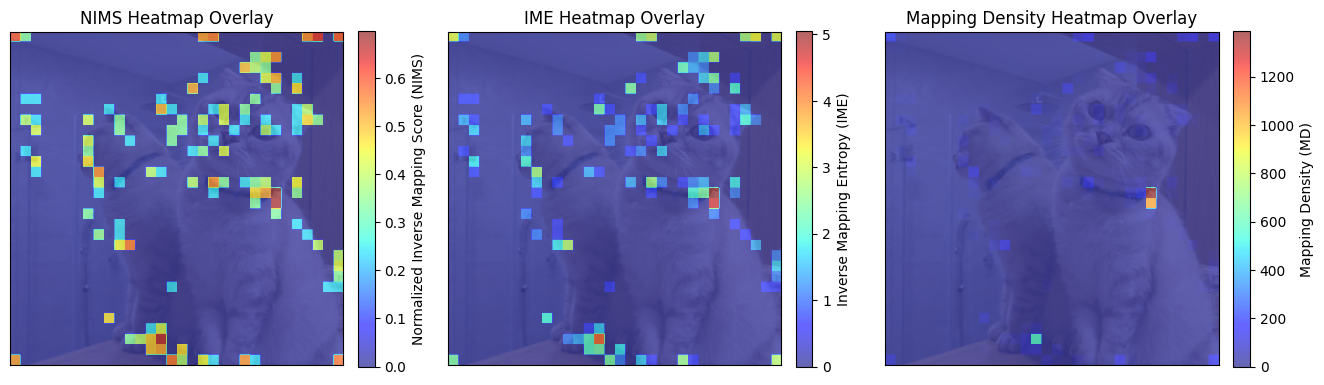

In [116]:

    target_img_path = '/kaggle/input/catoos/Dataset_Cats/source_cat.png'
    target_img = cv2.imread(target_img_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    
    # Resize image to match the 32x32 grid scale (assuming original is larger)
    img_size = 320  # Example target size (adjust if needed)
    grid_size = 32
    cell_size = 320//32
    target_img = cv2.resize(target_img, (img_size, img_size))

    # Resize NIMS grid to match image size for overlaying
    nims_resized = cv2.resize(nims_grid_2.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)
    ime_resized = cv2.resize(ime_grid_2.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)
    md_resized = cv2.resize(md_grid_2.astype(float), (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Create a side-by-side visualization: (1) Heatmap overlay (2) Numeric overlay on the image
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))

    # --- First Plot: Heatmap Overlay ---
    axes[0].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[0].imshow(nims_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=nims_grid_2.max()))

    # Add color bar for heatmap
    fig.colorbar(heatmap, ax=axes[0], fraction=0.046, pad=0.04, label="Normalized Inverse Mapping Score (NIMS)")

    # Hide axis labels
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("NIMS Heatmap Overlay")

    # --- Second Plot: Heatmap Overlay ---
    axes[1].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[1].imshow(ime_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=ime_grid_2.max()))
    fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04, label="Inverse Mapping Entropy (IME)")

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title("IME Heatmap Overlay")

    # --- Third Plot: Heatmap Overlay ---
    axes[2].imshow(target_img, alpha=0.5)  # Target image with transparency
    heatmap = axes[2].imshow(md_resized, cmap="jet", alpha=0.6, norm=mcolors.Normalize(vmin=0, vmax=md_grid_2.max()))
    
    fig.colorbar(heatmap, ax=axes[2], fraction=0.046, pad=0.04, label="Mapping Density (MD)")
    
    # Hide axis labels
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title("Mapping Density Heatmap Overlay")


# Methodology 

In [117]:
# We now define some points which are not keypoints 
slices_of_interest = [(j,i) for i in range(32) for j in range(32)]
first_pass = organized_df[organized_df["Source"].isin(slices_of_interest)].copy()

# Display(normal_df) # To check the normal_df 
# visualize_keypoints(first_pass, source_image_path,target_image_path ) # -> to visualize the points 

# keeping only those points whose IME is less than 2 and MSE is less than 20 
first_pass_df = first_pass[
    (first_pass["IME"] <= 2) &
    (first_pass["MSE (Src vs. Tgt→Src)"] < 20)
].copy()

# display(first_pass_df)
# print("total keypoints are ", len(first_pass_df))

# We now only keep unique (Step 1, Step 2, Step 3) triplet. 
max_repeats = 1  # Adjust this number as needed
first_pass_df = first_pass_df.groupby(["Step 1 (Src)", "Step 2 (Src → Tgt)", "Step 3 (Tgt → Src)"]).head(max_repeats).copy()

In [118]:
#print("filtered df without repeats")
display(first_pass_df)
# print("total keypoints are ", len(first_pass_df) )
#visualize_keypoints(first_pass_df, source_image_path,target_image_path )

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
9       (0, 1)       (1, 2)            (4, 31)             (0, 0)   
15      (0, 2)       (1, 3)            (4, 31)             (0, 0)   
21      (0, 3)       (1, 4)            (4, 31)             (0, 0)   
373    (1, 20)      (2, 21)            (6, 30)            (3, 22)   
637    (2, 18)      (3, 19)            (3, 13)            (3, 23)   
...        ...          ...                ...                ...   
8524  (30, 17)     (31, 18)           (30, 19)           (31, 18)   
8533  (30, 18)     (31, 19)           (30, 18)           (31, 19)   
8542  (30, 19)     (31, 20)           (30, 18)           (31, 19)   
8587  (30, 24)     (31, 25)           (29, 18)           (31, 31)   
8596  (30, 25)     (31, 26)           (29, 18)           (31, 31)   

      MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  \
9                       2.5             1.600804             0.590957   
15                      5.0             0.999638             0.751629   
21                      8.5             0.999638             0.881970   
373                     1.0             2.236833             2.187503   
637                     8.0             2.429747             2.742894   
...                     ...                  ...                  ...   
8524                    0.0             0.936783             0.444612   
8533                    0.0             1.354634             1.275753   
8542                    0.5             1.691242             0.682446   
8587                   18.0             1.190361             1.638811   
8596                   12.5             0.877639             1.166553   

      MD Density     IME    NIMS  
9             63  1.9459  0.4697  
15            63  1.9459  0.4697  
21            63  1.9459  0.4697  
373           18  0.6931  0.2398  
637            9 -0.0000 -0.0000  
...          ...     ...     ...  
8524          15  0.6730  0.2485  
8533          18  1.0986  0.3801  
8542          18  1.0986  0.3801  
8587          12  0.6931  0.2789  
8596          12  0.6931  0.2789  

[157 rows x 10 columns]

In [119]:
def extract_step1_tuples(filt_df: pd.DataFrame) -> list:
    """
    Extracts the 'Step 1 (Src)' column from the given DataFrame and returns it as a list of tuples.
    
    :param filt_df: A pandas DataFrame containing the relevant columns.
    :return: A list of tuples representing 'Step 1 (Src)'.
    """
    return filt_df['Step 2 (Src → Tgt)'].tolist()


second_pass_coordinates = extract_step1_tuples(first_pass_df)

In [120]:
print(second_pass_coordinates)

[(4, 31), (4, 31), (4, 31), (6, 30), (3, 13), (6, 30), (6, 28), (4, 14), (3, 5), (6, 19), (6, 28), (6, 28), (17, 31), (17, 31), (13, 26), (14, 24), (6, 19), (6, 19), (14, 25), (14, 21), (14, 22), (14, 24), (8, 16), (17, 31), (17, 31), (21, 13), (16, 25), (15, 25), (15, 26), (14, 23), (13, 26), (13, 26), (17, 31), (14, 20), (13, 26), (14, 25), (14, 26), (14, 26), (4, 13), (14, 18), (21, 13), (8, 5), (15, 25), (14, 26), (15, 22), (15, 25), (15, 26), (18, 22), (15, 23), (5, 13), (14, 18), (7, 12), (16, 24), (16, 25), (18, 25), (13, 22), (13, 18), (19, 25), (18, 25), (18, 25), (13, 22), (13, 18), (19, 25), (21, 19), (20, 22), (20, 21), (18, 25), (20, 21), (4, 13), (13, 19), (13, 18), (9, 17), (15, 25), (19, 31), (21, 19), (16, 22), (16, 22), (11, 26), (5, 13), (14, 18), (20, 23), (18, 23), (15, 22), (16, 21), (12, 17), (5, 13), (18, 1), (16, 20), (16, 21), (22, 18), (18, 1), (18, 22), (18, 22), (18, 22), (23, 18), (9, 3), (13, 2), (12, 18), (8, 4), (18, 22), (12, 17), (22, 18), (9, 3), (8,

In [121]:
arg_second_pass, kl_second_pass, trace_second_pass = entire_pass(
    averaged_map_target, 
    averaged_map_target_to_source, 
    averaged_map_source_to_target, 
    second_pass_coordinates
)

In [122]:
mse_second_pass = compute_mse(trace_second_pass)
second_pass_df = organize_results(trace_second_pass, mse_second_pass, kl_second_pass)
# Apply the function safely
second_pass_df["Step 1 (Src)"] = second_pass_df["Step 1 (Src)"].apply(parse_tuple)
second_pass_df["Step 2 (Src → Tgt)"] = second_pass_df["Step 2 (Src → Tgt)"].apply(parse_tuple)

In [123]:
second_df = second_pass_df[(second_pass_df["MSE (Src vs. Tgt→Src)"] < 20)
].copy()
display(second_df)

Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
0     (4, 31)      (3, 30)             (0, 1)            (7, 31)   
9     (6, 30)      (6, 29)            (3, 22)            (7, 31)   
10    (6, 30)      (6, 30)            (3, 22)            (7, 31)   
11    (6, 30)      (6, 31)            (3, 23)            (6, 30)   
14    (6, 30)      (7, 31)             (8, 7)            (7, 31)   
..        ...          ...                ...                ...   
721  (29, 18)     (29, 17)           (31, 31)           (30, 16)   
722  (29, 18)     (29, 18)           (31, 31)           (30, 16)   
724  (29, 18)     (30, 17)           (31, 31)           (30, 16)   
725  (29, 18)     (30, 18)           (31, 19)           (30, 18)   
726  (29, 18)     (30, 19)           (31, 18)           (30, 19)   

     MSE (Src vs. Tgt→Src)  KL (Ref || Tgt→Src)  KL (Tgt→Src || Src)  
0                      8.5             0.000000             0.768275  
9                      2.5             1.551313             0.206577  
10                     1.0             1.551313             0.206577  
11                     0.5             1.080821             0.367130  
14                     0.0             2.941154             0.745232  
..                     ...                  ...                  ...  
721                    1.0             0.952300             0.767295  
722                    2.5             0.952300             0.767295  
724                    0.5             0.952300             0.767295  
725                    0.0             2.093498             1.270583  
726                    0.0             3.341649             3.201478  

[429 rows x 7 columns]

In [124]:
# Define the maximum allowed repeats for each unique (Step 1, Step 2, Step 3) triplet
max_repeats = 1 
second_df = second_df.groupby(["Step 1 (Src)", "Step 2 (Src → Tgt)", "Step 3 (Tgt → Src)"]).head(max_repeats).copy()
#display(second_df)
print(len(second_df))

163


In [125]:
import pandas as pd

second_df_nims = second_df.copy()
second_df_nims["IME"] = second_df.apply(
    lambda row: organized_df_2.loc[
    (organized_df_2["Step 1 (Src)"] == row["Step 1 (Src)"]) &
    (organized_df_2["Step 2 (Src → Tgt)"] == row["Step 2 (Src → Tgt)"]) &
    (organized_df_2["Step 3 (Tgt → Src)"] == row["Step 3 (Tgt → Src)"]),
    "IME"
    ].values[0] if not organized_df_2.loc[
        (organized_df_2["Step 1 (Src)"] == row["Step 1 (Src)"]) &
        (organized_df_2["Step 2 (Src → Tgt)"] == row["Step 2 (Src → Tgt)"]) &
        (organized_df_2["Step 3 (Tgt → Src)"] == row["Step 3 (Tgt → Src)"]),
        "IME"
    ].empty else None,
    axis=1
)
#display(second_df_nims)
    


In [126]:
print(len(second_df_nims))
second_pass_df = second_df_nims[
    (second_df_nims["IME"] <= 2)].copy()
#display(second_pass_df)

163


In [127]:
print(len(second_pass_df))

95


In [128]:
#visualize_keypoints(final_df, target_image_path,source_image_path )

In [129]:
combined_paths = []

# Iterate through first pass mappings
for _, row in first_pass_df.iterrows():
    src = row["Source"]
    step1 = row["Step 1 (Src)"]
    step2 = row["Step 2 (Src → Tgt)"]
    step3 = row["Step 3 (Tgt → Src)"]

    # Find all second-pass mappings where Step 2 from first pass is Step 1 in second pass
    second_pass_matches = second_pass_df[second_pass_df["Source"] == step2]

    if not second_pass_matches.empty:
        for _, second_row in second_pass_matches.iterrows():
            new_step1 = second_row["Step 1 (Src)"]
            new_step2 = second_row["Step 2 (Src → Tgt)"]
            new_step3 = second_row["Step 3 (Tgt → Src)"]

            combined_paths.append({
                "Initial Source": src,
                "Step 1 (Src)": step1,
                "Step 2 (Src → Tgt)": step2,
                "Step 3 (Tgt → Src)": step3,
                "Step 4 (Src)": new_step1,
                "Step 5 (Src → Tgt)": new_step2,
                "Step 6 (Tgt → Src)": new_step3,
            })
    else:
        # If no second-pass mapping is found, just keep the first-pass path
        combined_paths.append({
            "Initial Source": src,
            "Step 1 (Src)": step1,
            "Step 2 (Src → Tgt)": step2,
            "Step 3 (Tgt → Src)": step3,
            "Step 4 (Src)": None,
            "Step 5 (Src → Tgt)": None,
            "Step 6 (Tgt → Src)": None,
        })

# Convert to DataFrame for visualization
total_df = pd.DataFrame(combined_paths)

In [130]:
total_df = total_df.dropna()


In [131]:
# MSE between the second pass 
step_1_array = np.array([list(tup) for tup in total_df["Step 1 (Src)"]])
step_5_array = np.array([list(tup) for tup in total_df["Step 5 (Src → Tgt)"]])

# Compute Mean Squared Error (MSE) for each row
mse_values = np.mean((step_1_array - step_5_array) ** 2, axis=1)

# Add MSE column to DataFrame
total_df["MSE (Step 1 vs Step 5)"] = mse_values

step_4_array = np.array([list(tup) for tup in total_df["Step 4 (Src)"]])
step_6_array = np.array([list(tup) for tup in total_df["Step 6 (Tgt → Src)"]])

# Compute Mean Squared Error (MSE) for each row
mse_values = np.mean((step_4_array - step_6_array) ** 2, axis=1)

# Add MSE column to DataFrame
total_df["MSE (Step 4 vs Step 6)"] = mse_values

display(total_df)

Initial Source Step 1 (Src) Step 2 (Src → Tgt) Step 3 (Tgt → Src)  \
0           (0, 1)       (1, 2)            (4, 31)             (0, 0)   
1           (0, 2)       (1, 3)            (4, 31)             (0, 0)   
2           (0, 3)       (1, 4)            (4, 31)             (0, 0)   
3          (1, 20)      (2, 21)            (6, 30)            (3, 22)   
4          (1, 20)      (2, 21)            (6, 30)            (3, 22)   
..             ...          ...                ...                ...   
252       (28, 14)     (29, 15)           (30, 19)           (31, 18)   
253       (28, 15)     (29, 16)            (28, 8)           (30, 16)   
259       (29, 10)     (30, 11)           (31, 17)           (30, 11)   
260       (29, 11)     (30, 12)           (31, 17)           (30, 11)   
269       (30, 17)     (31, 18)           (30, 19)           (31, 18)   

    Step 4 (Src) Step 5 (Src → Tgt) Step 6 (Tgt → Src)  \
0        (3, 30)             (0, 1)            (7, 31)   
1        (3, 30)             (0, 1)            (7, 31)   
2        (3, 30)             (0, 1)            (7, 31)   
3        (6, 31)            (3, 23)            (6, 30)   
4        (7, 31)             (8, 7)            (7, 31)   
..           ...                ...                ...   
252     (31, 18)           (30, 12)           (31, 17)   
253      (27, 8)           (23, 31)            (27, 8)   
259     (31, 17)           (30, 11)           (31, 17)   
260     (31, 17)           (30, 11)           (31, 17)   
269     (31, 18)           (30, 12)           (31, 17)   

     MSE (Step 1 vs Step 5)  MSE (Step 4 vs Step 6)  
0                       1.0                     8.5  
1                       2.5                     8.5  
2                       5.0                     8.5  
3                       2.5                     0.5  
4                     116.0                     0.0  
..                      ...                     ...  
252                     5.0                     0.5  
253                   130.5                     0.0  
259                     0.0                     0.0  
260                     0.5                     0.0  
269                    18.5                     0.5  

[205 rows x 9 columns]

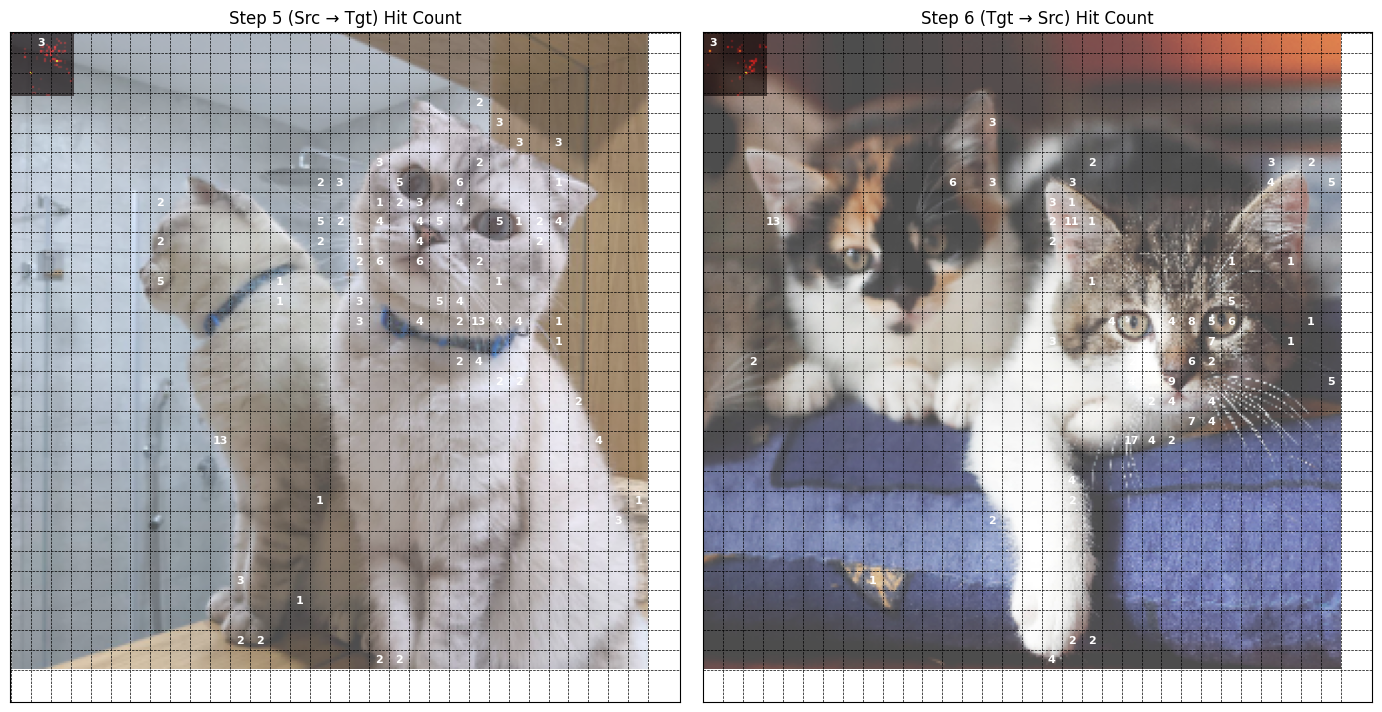

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
source_image_path = '/kaggle/input/catoos/Dataset_Cats/source_cat.png'
target_image_path = '/kaggle/input/catoos/Dataset_Cats/target_cat.jpeg'


# Ensure necessary data is available
try:
    # Extract Step 5 (Src -> Tgt) and Step 6 (Tgt -> Src) coordinates
    step_5_coords = total_df["Step 5 (Src → Tgt)"].apply(lambda x: eval(str(x))).tolist()
    step_6_coords = total_df["Step 6 (Tgt → Src)"].apply(lambda x: eval(str(x))).tolist()

    # Define grid size and image dimensions
    grid_size = 32
    img_size = 320  # Assuming a 320x320 image for visualization
    cell_size = img_size // grid_size

    # Create hit count grids
    step_5_grid = np.zeros((grid_size, grid_size))
    step_6_grid = np.zeros((grid_size, grid_size))

    # Populate the grids with hit counts
    for y, x in step_5_coords:
        step_5_grid[y, x] += 1

    for y, x in step_6_coords:
        step_6_grid[y, x] += 1

    # Load and resize images
    source_img = cv2.cvtColor(cv2.resize(cv2.imread(source_image_path), (img_size, img_size)), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.resize(cv2.imread(target_image_path), (img_size, img_size)), cv2.COLOR_BGR2RGB)

    # Plot the heatmap overlays with numeric grid overlays
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Step 5 visualization (Source image overlay with grid values)
    axes[0].imshow(source_img, alpha=0.7)
    axes[0].imshow(step_5_grid, cmap="hot", alpha=0.6)
    axes[0].set_title("Step 5 (Src → Tgt) Hit Count")

    # Overlay grid lines and numeric values
    for i in range(grid_size + 1):
        axes[0].axhline(i * cell_size, color='black', linestyle='--', linewidth=0.5)
        axes[0].axvline(i * cell_size, color='black', linestyle='--', linewidth=0.5)

    for i in range(grid_size):
        for j in range(grid_size):
            if step_5_grid[i, j] > 0:
                axes[0].text(j * cell_size + cell_size // 2,
                             i * cell_size + cell_size // 2,
                             f"{int(step_5_grid[i, j])}",
                             color="white", fontsize=8, ha="center", va="center", fontweight="bold")

    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Step 6 visualization (Target image overlay with grid values)
    axes[1].imshow(target_img, alpha=0.7)
    axes[1].imshow(step_6_grid, cmap="hot", alpha=0.6)
    axes[1].set_title("Step 6 (Tgt → Src) Hit Count")

    # Overlay grid lines and numeric values
    for i in range(grid_size + 1):
        axes[1].axhline(i * cell_size, color='black', linestyle='--', linewidth=0.5)
        axes[1].axvline(i * cell_size, color='black', linestyle='--', linewidth=0.5)

    for i in range(grid_size):
        for j in range(grid_size):
            if step_6_grid[i, j] > 0:
                axes[1].text(j * cell_size + cell_size // 2,
                             i * cell_size + cell_size // 2,
                             f"{int(step_6_grid[i, j])}",
                             color="white", fontsize=8, ha="center", va="center", fontweight="bold")

    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Error: {e}. Ensure `total_df` and image paths are defined.")



In [132]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random

## This function takes the original picture as the source. 

def visualize_keypoints_extended(filtered_df, source_image_path, target_image_path):
    """
    Visualizes keypoints across multiple steps:
    - All keypoints are plotted on the images.
    - Only 3 random keypoints per step are shown in the text box for readability.

    Parameters:
        filtered_df (pd.DataFrame): DataFrame containing keypoints from both passes.
        source_image_path (str): Path to the source image.
        target_image_path (str): Path to the target image.
    """

    # Load and resize images
    source_img = cv2.cvtColor(cv2.resize(cv2.imread(source_image_path), (320, 320)), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.resize(cv2.imread(target_image_path), (320, 320)), cv2.COLOR_BGR2RGB)

    cmap = plt.get_cmap("tab10")  # Updated colormap usage

    # Ensure correct column naming in the DataFrame
    if "Initial Source" not in filtered_df.columns:
        raise KeyError("Column 'Initial Source' not found in DataFrame. Check your input.")

    # Group by unique Initial Source points
    for source, group in filtered_df.groupby("Initial Source"):
        try:
            # Convert coordinates while handling missing values
            def get_coords(column):
                coords = [eval(str(x)) for x in group[column] if pd.notna(x)]
                return np.array(coords)

            src_coords = get_coords("Step 1 (Src)")
            inter_coords = get_coords("Step 2 (Src → Tgt)")
            trg_coords = get_coords("Step 3 (Tgt → Src)")
            src_coords_2 = get_coords("Step 4 (Src)")
            inter_coords_2 = get_coords("Step 5 (Src → Tgt)")
            trg_coords_2 = get_coords("Step 6 (Tgt → Src)")
            
        except Exception as e:
            print(f"Error processing keypoints for source {source}: {e}")
            continue

        # Prepare coordinates for visualization (all points will be displayed)
        coords_list = [src_coords, inter_coords, trg_coords, src_coords_2, inter_coords_2, trg_coords_2]

        # Gather coordinates for label box (only 3 random points per step)
        def sample_coords(coords):
            if len(coords) > 3:
                return random.sample(coords.tolist(), 3)  # Select 3 random points
            return coords.tolist()

        text_coords_list = [sample_coords(coords) for coords in coords_list]

        # Get unique points for color mapping
        all_coords = np.vstack([c for c in coords_list if c.size > 0])
        unique_points, indices = np.unique(all_coords, axis=0, return_inverse=True)
        colors = [cmap(i % 10) for i in indices]

        # Plot the keypoints across 6 images + extra space for labels
        fig, axes = plt.subplots(1, 7, figsize=(22, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 0.5]})
        titles = [
            f"Initial Source [{source}]",
            "Step 2 (Target)",
            "Step 3 (Back to Source)",
            "Step 4 (Src)",
            "Step 5 (Src → Tgt)",
            "Step 6 (Tgt → Src)"
        ]
        images = [source_img, target_img, source_img, target_img, source_img, target_img]

        for ax, img, coords, title in zip(axes[:-1], images, coords_list, titles):
            ax.imshow(img, alpha=0.5)  # Dim image for better visibility
            if coords.size:  # Scatter all valid coordinates
                for i, (y, x) in enumerate(coords):
                    ax.scatter(x * 10, y * 10, color=colors[i], s=40, marker='x', edgecolors='black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title, fontsize=10)

        # Extra subplot for displaying coordinate labels (only 3 per step)
        axes[-1].axis("off")  # Hide axis
        text = "\n".join([
            f"Step {i+1}: {coords}" for i, coords in enumerate(text_coords_list) if coords
        ])
        axes[-1].text(0, 1, text, fontsize=10, verticalalignment="top", fontfamily="monospace")

        plt.tight_layout()
        plt.show()

# Example usage:
#visualize_keypoints_extended(total_df, source_image_path, target_image_path)


In [134]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random

def visualize_keypoints_extended(filtered_df, source_image_path, target_image_path):
    """
    Visualizes keypoints across multiple steps:
    - All keypoints are plotted on the images.
    - Only 3 random keypoints per step are shown in the text box for readability.

    Parameters:
        filtered_df (pd.DataFrame): DataFrame containing keypoints from both passes.
        source_image_path (str): Path to the source image.
        target_image_path (str): Path to the target image.
    """

    # Load and resize images
    source_img = cv2.cvtColor(cv2.resize(cv2.imread(source_image_path), (320, 320)), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.resize(cv2.imread(target_image_path), (320, 320)), cv2.COLOR_BGR2RGB)

    cmap = plt.get_cmap("tab10")  # Updated colormap usage

    # Ensure correct column naming in the DataFrame
    if "Initial Source" not in filtered_df.columns:
        raise KeyError("Column 'Initial Source' not found in DataFrame. Check your input.")

    # Group by unique Initial Source points
    for source, group in filtered_df.groupby("Step 1 (Src)"):
        try:
            # Convert coordinates while handling missing values
            def get_coords(column):
                coords = [eval(str(x)) for x in group[column] if pd.notna(x)]
                return np.array(coords)

            inter_coords = get_coords("Step 2 (Src → Tgt)")
            trg_coords = get_coords("Step 3 (Tgt → Src)")
            src_coords_2 = get_coords("Step 4 (Src)")
            inter_coords_2 = get_coords("Step 5 (Src → Tgt)")
            trg_coords_2 = get_coords("Step 6 (Tgt → Src)")
            
        except Exception as e:
            print(f"Error processing keypoints for source {source}: {e}")
            continue

        # Prepare coordinates for visualization (all points will be displayed)
        coords_list = [inter_coords, trg_coords, src_coords_2, inter_coords_2, trg_coords_2]

        # Gather coordinates for label box (only 3 random points per step)
        def sample_coords(coords):
            if len(coords) > 3:
                return random.sample(coords.tolist(), 3)  # Select 3 random points
            return coords.tolist()

        text_coords_list = [sample_coords(coords) for coords in coords_list]

        # Get unique points for color mapping
        all_coords = np.vstack([c for c in coords_list if c.size > 0])
        unique_points, indices = np.unique(all_coords, axis=0, return_inverse=True)
        colors = [cmap(i % 10) for i in indices]

        # Plot the keypoints across 6 images + extra space for labels
        fig, axes = plt.subplots(1, 6, figsize=(22, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.5]})
        titles = [
            f"Step 1 (Target) [{source}]",
            "Step 2 (Back to Source)",
            "Step 3 (Src)",
            "Step 4 (Src → Tgt)",
            "Step 5 (Tgt → Src)"
        ]
        images = [target_img, source_img, target_img, source_img, target_img]

        for ax, img, coords, title in zip(axes[:-1], images, coords_list, titles):
            ax.imshow(img, alpha=0.5)  # Dim image for better visibility
            if coords.size:  # Scatter all valid coordinates
                for i, (y, x) in enumerate(coords):
                    ax.scatter(x * 10, y * 10, color=colors[i], s=40, marker='x', edgecolors='black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title, fontsize=10)

        # Extra subplot for displaying coordinate labels (only 3 per step)
        axes[-1].axis("off")  # Hide axis
        text = "\n".join([
            f"Step {i+1}: {coords}" for i, coords in enumerate(text_coords_list) if coords
        ])
        axes[-1].text(0, 1, text, fontsize=10, verticalalignment="top", fontfamily="monospace")

        plt.tight_layout()
        plt.show()

#visualize_keypoints_extended(total_df, source_image_path, target_image_path)
